In [1]:
from typing import Union
import pdb
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import numpy as np
import control
import pdb
from jax.flatten_util import ravel_pytree
import jax
import lineax

from helpers_impl import  NeuralSDEKuramoto, get_gpu_memory, adj_lattice, criticalK, objective, order_param, objective_test
from tqdm import tqdm
from diffrax import diffeqsolve, Tsit5, ODETerm, ReversibleHeun, Heun
import gc
from IPython.display import clear_output
gc.collect()  
print(get_gpu_memory())
jax.config.update("jax_enable_x64", False)

[{'device': 0, 'total_memory': 24564.0, 'free_memory': 23212.25, 'used_memory': 1351.75}]


In [3]:
batch_size = 1
scale=5
scale_kin=5
lattice=True
diff=0
nobs=0

print(get_gpu_memory())
%store -r Astored
A = Astored

data_size=Astored.shape[1]
#freqs=np.random.randn(batch_size,data_size)/scale_kin
print(get_gpu_memory())
Kcrit, L=criticalK(A,data_size,scale)
A=jnp.array(A)
L=jnp.array(L)
alpha=0.9
print(get_gpu_memory())
skip=True


ema_loss=0
ema_ener=0
Kcrit=0.01*Kcrit

hidden_size=data_size

width_size=2*data_size
depth=5



# Create an ensemble of models
print(Kcrit)
print(get_gpu_memory())

[{'device': 0, 'total_memory': 24564.0, 'free_memory': 22950.75, 'used_memory': 1613.25}]
[{'device': 0, 'total_memory': 24564.0, 'free_memory': 22938.75, 'used_memory': 1625.25}]
[{'device': 0, 'total_memory': 24564.0, 'free_memory': 4650.4375, 'used_memory': 19913.5625}]
1.027290192722833
[{'device': 0, 'total_memory': 24564.0, 'free_memory': 4650.4375, 'used_memory': 19913.5625}]


In [48]:
 

t_size=32
t0 = 0
t1 = 1
ts = jnp.linspace(t0, t1, t_size)
tss = jnp.expand_dims(ts, axis=0)
tsss = jnp.repeat(tss, repeats=batch_size, axis=0)
#initialize the ODE

seed=5679
key = jr.PRNGKey(seed)
strategy="vector"
generator=NeuralSDEKuramoto(
        data_size,
        hidden_size,
        width_size,
        depth,
        strategy,
        key=key
    )
#learning rate
learning_rate=0.0001

#adam optimizer
b1=0.9
b2=0.999
eps=1e-08
optim = optax.adam(learning_rate, b1=b1, b2=b2, eps=0, eps_root=eps)

opt_state = optim.init(eqx.filter(generator, eqx.is_inexact_array))
R=0.0

freqs=np.random.randn(batch_size,data_size)/scale
K0 = jnp.repeat(Kcrit, repeats=batch_size, axis=0) 
A0= jnp.repeat(jnp.expand_dims(A, axis=0), repeats=batch_size, axis=0)

%store freqs

#initial conditions 
#y00=jnp.append(x00, jnp.zeros((1,1)))
#y0 = jnp.expand_dims(y00, axis=0)
y0=np.random.randn(batch_size,data_size)/scale_kin  

%store y0
x00=jnp.squeeze(y0, axis=0)
y00=jnp.append(x00, jnp.zeros((1,1)))
#common denominator term
@jax.jit
def smoothed_inverse_grad(grad, eps=1e-05):
    return 1.0 / jnp.sqrt(grad + eps)

#for cost and its gradient evaluation
@eqx.filter_value_and_grad  
def loss(model):
   
    pred_y = jax.vmap(model)(tsss, y0, freqs, A0, K0)
    pred=jnp.squeeze(pred_y[0,-1,0:hidden_size])

    los_energy =jnp.mean( objective(pred,jnp.squeeze(A0, axis=0)))

    return los_energy


@eqx.filter_jit
def predict(flat_params, static, unravel_fn):
    unflat_params = unravel_fn(flat_params)
    modelx = eqx.combine(static, unflat_params)
    
    pred_y = jax.vmap(modelx)(tsss, y0, freqs, A0, K0)
    pred=jnp.squeeze(pred_y[0,-1,0:hidden_size])

   

    return pred

#for energy and its gradient evaluation
@eqx.filter_value_and_grad  
def loss_kin(model):
   
    pred_y = jax.vmap(model)(tsss,  y0, freqs, A0, K0)
    
    kin_energy=  jnp.mean(pred_y[:,-1,-1])

    return kin_energy

#for Hessian evaluation
@eqx.filter_jit
def l1(flat_params, static, unravel_fn):

    unflat_params = unravel_fn(flat_params)
    modelx = eqx.combine(static, unflat_params)

    if strategy=="scalar":
        vf = diffrax.ODETerm(modelx.vf)  # Drift term
    elif strategy=="vector":
        vf= diffrax.ODETerm(modelx.vf_vec)
    else:
        vf=diffrax.ODETerm(modelx.vf_vec_cl)

    
    solver = Heun(scan_kind="bounded")
    t0 = ts[0]
    t1 = ts[-1]
   
    dt=(t1-t0)/ts.shape[0]
 
    saveat = diffrax.SaveAt(ts=ts)
    args = (jnp.squeeze(freqs, axis=0), jnp.squeeze(A0, axis=0), K0)

    pred_y = diffeqsolve(vf, solver, t0=t0, t1=t1, dt0=dt, y0=y00, args=args)
    pred=pred_y.ys[-1,0:hidden_size]

    los_energy = jnp.mean( objective(pred,jnp.squeeze(A0, axis=0)))
    score= los_energy

    return score

#for evaluation of directional derivatives of control energy
@jax.jit
def rms_full_grad(flat_grads, flat_grads1, hessian, hessian2, params, eps, ema_grad, ema_sqr_grad, counter):
    #common denominator term
    ema_sqr_grad = ema_sqr_grad /(1-b2**(counter+1))
    ema_grad = ema_grad /(1-b1**(counter+1))
    denom= smoothed_inverse_grad((ema_sqr_grad), eps)
    dem2 = smoothed_inverse_grad((jnp.square(flat_grads)), eps)
    

    PP_ema= ema_grad * (hessian @ (ema_grad* denom) )
    PP_ema2= ema_grad * (hessian2 @ (ema_grad* denom) )
    
    P_multiplier=  learning_rate* denom * ((1+b1)/(1-b1)  +((1+b2)/(1-b2))* ( eps*denom**2 -1 ))/2 


    kin_decline_from_loss = -jnp.dot(flat_grads1, (ema_grad* denom)) 
    kin_decline_from_P_term = - jnp.dot(flat_grads1, PP_ema * P_multiplier ) 
    kin_decline_from_P_term2 = - jnp.dot(flat_grads1, PP_ema2 * P_multiplier )

    jax.debug.print("directional derivative along unmodified loss = {}", kin_decline_from_loss)
    jax.debug.print("directional derivative along bias term = {}",  kin_decline_from_P_term)
    jax.debug.print("directional derivative along bias term2 = {}",  kin_decline_from_P_term2)
    return kin_decline_from_loss, kin_decline_from_P_term
    
@eqx.filter_jit
def make_step(model, batch_size, tsss, key, opt_state, y0,  ema_grad, ema_sqr_grad, counter):

    key = jr.split(key, batch_size)
    
    #evaluate loss, energy and gradients
    value, grads = loss(model)
    value1, grads1 = loss_kin(model)

    #hessian evaluation
    arr, static = eqx.partition(model, eqx.is_inexact_array)
    params, unravel_fn = ravel_pytree(arr)
    hessian=jax.hessian(l1)(params, static, unravel_fn)
    
    x=predict(params, static, unravel_fn)
    diff = x[:, jnp.newaxis] - x[jnp.newaxis, :]

    jacob=jax.jacobian(predict)(params, static,unravel_fn)
    cos_2diff = jnp.cos(2 * diff)

    jax.debug.print("hessian1 = {}", jnp.linalg.norm(hessian))
    #jax.debug.print("hessian2 = {}",  jnp.linalg.norm(hessian2))

    # First term
    
    hessian2 = jnp.zeros((params.shape[0], params.shape[0]))  # Shape: (M, M)
    
    # First term
    for j in range(x.shape[0]):
        J_diff = jacob[j] - jacob  # Shape: (N, M)
        # Compute weighted outer product: sum_i A[j,i] * cos(2 * diff[j,i]) * J_diff[i,l] * jacob[j,k]
        weights = jnp.squeeze(A0, axis=0)[j] * cos_2diff[j]  # Shape: (N,)
        hessian2 += 2 * jnp.einsum('i,il,ik->lk', weights, J_diff, jacob[j, jnp.newaxis])
    jax.debug.print("hessian2 = {}",  jnp.linalg.norm(hessian2))


    #flattening the gradients
    flat_grads, _ = ravel_pytree(eqx.filter(grads, eqx.is_inexact_array))
    flat_grads1, _ = ravel_pytree(eqx.filter(grads1, eqx.is_inexact_array))

    #evaluation of ema gradients
    ema_grad = b1*ema_grad + (1-b1) * flat_grads
    ema_sqr_grad = b2*ema_sqr_grad + (1-b2) * jnp.square(flat_grads)

    cos_theta_grad_loss, cos_theta_grad_kin=rms_full_grad(flat_grads, flat_grads1, hessian,hessian2,params, eps, ema_grad, ema_sqr_grad, counter)

    #update the control network
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    counter+=1
    return model, opt_state, grads, value, value1, cos_theta_grad_kin, cos_theta_grad_loss, jnp.linalg.norm(params), ema_grad, ema_sqr_grad, counter

#compute the first values of cost and energy for ema 
tot_iter=100000
losses, grads = loss(generator)
kin, grads1 = loss_kin(generator)
arr, static = eqx.partition(generator, eqx.is_inexact_array)
params, unravel_fn = ravel_pytree(arr)
flat_grads, _ = ravel_pytree(eqx.filter(grads, eqx.is_inexact_array))
ema_grad =  flat_grads
ema_sqr_grad = jnp.square(flat_grads)

Stored 'freqs' (ndarray)
Stored 'y0' (ndarray)


In [50]:
#save costs and energy
saved_loss=[]
saved_kin=[]
#save directional derivatives
saved_product1=[]
saved_product2=[]

ini_key=jr.PRNGKey(seed)
key= jr.split(key, 1)[0]
alpha=0.9

counter=jnp.int32(0)
tsss = jnp.repeat(tss, repeats=batch_size, axis=0)

score=10000000
epochs=[]
ema_loss=0
for k in tqdm(range(0,tot_iter)):
   
    key= jr.split(key, 1)[0]
    #run optimization steps, evaluate the cost and energy, directional derivatives
    generator, opt_state, grads, losses, kin, cos_theta_imp, cos_theta_loss, param_norm, ema_grad, ema_sqr_grad, counter= make_step(generator, batch_size, tsss, key, opt_state, y0,  ema_grad, ema_sqr_grad,counter)
    
    if k==0:
        ema_loss=losses
    else:
        ema_loss=ema_loss*alpha+losses*(1-alpha)
    
    if ema_loss<score:
        score=ema_loss

    print("ema loss")
    print(ema_loss)
    print("kin")
    print(kin)
    saved_loss.append(jax.device_get(losses))
    saved_kin.append(jax.device_get(kin))
    saved_product1.append(jax.device_get(cos_theta_imp))
    saved_product2.append(jax.device_get(cos_theta_loss))

    if k%500==0:
        gc.collect()
        clear_output(wait=True)
        
    if jnp.linalg.norm(ema_loss)<1e-06:
        break
    del grads, losses, kin



 28%|██▊       | 27502/100000 [5:02:11<15:22:43,  1.31it/s]

hessian2 = 282968.84375
hessian1 = 3.4518635272979736
directional derivative along bias term2 = 428541.4375
directional derivative along unmodified loss = 2724.8671875
directional derivative along bias term = 1.9913297891616821
ema loss
0.02317705
kin
847.653


 28%|██▊       | 27503/100000 [5:02:12<14:44:51,  1.37it/s]

hessian2 = 749516.25
hessian1 = 3.4476866722106934
directional derivative along bias term2 = 244266.296875
directional derivative along unmodified loss = -1070.0257568359375
directional derivative along bias term = 0.48106667399406433
ema loss
0.023173058
kin
847.9256


 28%|██▊       | 27504/100000 [5:02:12<14:18:00,  1.41it/s]

hessian2 = 521578.71875
hessian1 = 3.4500675201416016
directional derivative along bias term2 = 15593.203125
directional derivative along unmodified loss = -113.75782775878906
directional derivative along bias term = 0.05110214650630951
ema loss
0.023158358
kin
847.8186


 28%|██▊       | 27505/100000 [5:02:13<13:59:37,  1.44it/s]

hessian2 = 476570.1875
hessian1 = 3.450472354888916
directional derivative along bias term2 = 109468.078125
directional derivative along unmodified loss = 1428.2822265625
directional derivative along bias term = 0.2822578549385071
ema loss
0.02314771
kin
847.80725


 28%|██▊       | 27506/100000 [5:02:14<13:46:34,  1.46it/s]

hessian2 = 684197.6875
hessian1 = 3.447833299636841
directional derivative along bias term2 = 241576.625
directional derivative along unmodified loss = -915.5238037109375
directional derivative along bias term = 0.474137544631958
ema loss
0.023139296
kin
847.95


 28%|██▊       | 27507/100000 [5:02:14<13:37:21,  1.48it/s]

hessian2 = 469693.0
hessian1 = 3.449328899383545
directional derivative along bias term2 = 3524.171875
directional derivative along unmodified loss = 106.42375183105469
directional derivative along bias term = -0.006927976384758949
ema loss
0.023128068
kin
847.8585


 28%|██▊       | 27508/100000 [5:02:15<13:30:34,  1.49it/s]

hessian2 = 446982.75
hessian1 = 3.4493160247802734
directional derivative along bias term2 = 114439.171875
directional derivative along unmodified loss = 1324.16748046875
directional derivative along bias term = 0.4661734700202942
ema loss
0.023119
kin
847.86914


 28%|██▊       | 27509/100000 [5:02:16<13:25:44,  1.50it/s]

hessian2 = 646229.125
hessian1 = 3.44740629196167
directional derivative along bias term2 = 62080.01953125
directional derivative along unmodified loss = -466.68914794921875
directional derivative along bias term = 0.026738524436950684
ema loss
0.023111306
kin
848.0016


 28%|██▊       | 27510/100000 [5:02:16<13:22:30,  1.51it/s]

hessian2 = 519788.0
hessian1 = 3.4487791061401367
directional derivative along bias term2 = -1754.4638671875
directional derivative along unmodified loss = 239.531005859375
directional derivative along bias term = -0.03784999996423721
ema loss
0.023101341
kin
847.9549


 28%|██▊       | 27511/100000 [5:02:17<13:20:09,  1.51it/s]

hessian2 = 520606.9375
hessian1 = 3.448821783065796
directional derivative along bias term2 = 47021.37890625
directional derivative along unmodified loss = 945.8001098632812
directional derivative along bias term = 0.21509674191474915
ema loss
0.023092553
kin
847.9789


 28%|██▊       | 27512/100000 [5:02:18<13:17:59,  1.51it/s]

hessian2 = 648246.625
hessian1 = 3.4474778175354004
directional derivative along bias term2 = 81503.890625
directional derivative along unmodified loss = -390.82733154296875
directional derivative along bias term = 0.059658415615558624
ema loss
0.023085982
kin
848.0734


 28%|██▊       | 27513/100000 [5:02:18<13:18:11,  1.51it/s]

hessian2 = 511837.65625
hessian1 = 3.4482719898223877
directional derivative along bias term2 = -3358.50390625
directional derivative along unmodified loss = 539.1551513671875
directional derivative along bias term = -0.11684508621692657
ema loss
0.02307898
kin
848.0344


 28%|██▊       | 27514/100000 [5:02:19<13:17:39,  1.51it/s]

hessian2 = 525335.4375
hessian1 = 3.447310447692871
directional derivative along bias term2 = 23193.08203125
directional derivative along unmodified loss = 822.2715454101562
directional derivative along bias term = 0.10431668907403946
ema loss
0.023071801
kin
848.08826


 28%|██▊       | 27515/100000 [5:02:20<13:17:17,  1.52it/s]

hessian2 = 618158.6875
hessian1 = 3.446052074432373
directional derivative along bias term2 = 86673.03125
directional derivative along unmodified loss = -515.2703857421875
directional derivative along bias term = 0.08210135996341705
ema loss
0.023067579
kin
848.17053


 28%|██▊       | 27516/100000 [5:02:20<13:15:24,  1.52it/s]

hessian2 = 485153.40625
hessian1 = 3.44742488861084
directional derivative along bias term2 = -1240.209716796875
directional derivative along unmodified loss = 432.586181640625
directional derivative along bias term = -0.029237842187285423
ema loss
0.023062302
kin
848.119


 28%|██▊       | 27517/100000 [5:02:21<13:15:20,  1.52it/s]

hessian2 = 507705.34375
hessian1 = 3.447287082672119
directional derivative along bias term2 = 124552.3203125
directional derivative along unmodified loss = 1362.538330078125
directional derivative along bias term = 0.5847132802009583
ema loss
0.023057546
kin
848.1622


 28%|██▊       | 27518/100000 [5:02:22<13:14:29,  1.52it/s]

hessian2 = 708327.5
hessian1 = 3.445347547531128
directional derivative along bias term2 = 349971.125
directional derivative along unmodified loss = -1141.3905029296875
directional derivative along bias term = 0.5166821479797363
ema loss
0.02305796
kin
848.2985


 28%|██▊       | 27519/100000 [5:02:22<13:14:20,  1.52it/s]

hessian2 = 430871.3125
hessian1 = 3.4475948810577393
directional derivative along bias term2 = 22160.58984375
directional derivative along unmodified loss = 908.6985473632812
directional derivative along bias term = 0.08626513183116913
ema loss
0.023057941
kin
848.18427


 28%|██▊       | 27520/100000 [5:02:23<13:13:50,  1.52it/s]

hessian2 = 535011.875
hessian1 = 3.446094274520874
directional derivative along bias term2 = 62496.6796875
directional derivative along unmodified loss = 1089.089111328125
directional derivative along bias term = 0.30993175506591797
ema loss
0.023052134
kin
848.27515


 28%|██▊       | 27521/100000 [5:02:24<13:13:46,  1.52it/s]

hessian2 = 650278.4375
hessian1 = 3.444455623626709
directional derivative along bias term2 = 147683.65625
directional derivative along unmodified loss = -736.49609375
directional derivative along bias term = 0.15096598863601685
ema loss
0.023050614
kin
848.3841


 28%|██▊       | 27522/100000 [5:02:24<13:13:59,  1.52it/s]

hessian2 = 459237.59375
hessian1 = 3.4462568759918213
directional derivative along bias term2 = 30104.794921875
directional derivative along unmodified loss = 855.0104370117188
directional derivative along bias term = 0.20899808406829834
ema loss
0.02304849
kin
848.31055


 28%|██▊       | 27523/100000 [5:02:25<13:13:29,  1.52it/s]

hessian2 = 560947.25
hessian1 = 3.4452064037323
directional derivative along bias term2 = 38392.71875
directional derivative along unmodified loss = 876.5189208984375
directional derivative along bias term = 0.2201763242483139
ema loss
0.023043107
kin
848.39594


 28%|██▊       | 27524/100000 [5:02:26<13:13:51,  1.52it/s]

hessian2 = 667970.3125
hessian1 = 3.4441027641296387
directional derivative along bias term2 = 208936.21875
directional derivative along unmodified loss = -858.0150146484375
directional derivative along bias term = 0.24962326884269714
ema loss
0.02304125
kin
848.4837


 28%|██▊       | 27525/100000 [5:02:26<13:14:34,  1.52it/s]

hessian2 = 440643.5625
hessian1 = 3.4459686279296875
directional derivative along bias term2 = 48397.13671875
directional derivative along unmodified loss = 1074.169189453125
directional derivative along bias term = 0.2837291359901428
ema loss
0.023041597
kin
848.39777


 28%|██▊       | 27526/100000 [5:02:27<13:14:24,  1.52it/s]

hessian2 = 565755.3125
hessian1 = 3.4443199634552
directional derivative along bias term2 = 45681.8984375
directional derivative along unmodified loss = 955.6558837890625
directional derivative along bias term = 0.23810605704784393
ema loss
0.023036584
kin
848.50525


 28%|██▊       | 27527/100000 [5:02:28<13:14:10,  1.52it/s]

hessian2 = 682333.0625
hessian1 = 3.442953109741211
directional derivative along bias term2 = 367998.96875
directional derivative along unmodified loss = -1259.876708984375
directional derivative along bias term = 0.5410791635513306
ema loss
0.023037188
kin
848.60077


 28%|██▊       | 27528/100000 [5:02:28<13:14:37,  1.52it/s]

hessian2 = 386376.125
hessian1 = 3.4456021785736084
directional derivative along bias term2 = 71597.7265625
directional derivative along unmodified loss = 1242.405029296875
directional derivative along bias term = 0.4818575978279114
ema loss
0.023042213
kin
848.47485


 28%|██▊       | 27529/100000 [5:02:29<13:14:43,  1.52it/s]

hessian2 = 539211.125
hessian1 = 3.443751573562622
directional derivative along bias term2 = 145537.28125
directional derivative along unmodified loss = 1395.68994140625
directional derivative along bias term = 0.6847279667854309
ema loss
0.023037199
kin
848.5991


 28%|██▊       | 27530/100000 [5:02:30<13:14:29,  1.52it/s]

hessian2 = 756170.625
hessian1 = 3.441812515258789
directional derivative along bias term2 = 1032769.5625
directional derivative along unmodified loss = -2215.351318359375
directional derivative along bias term = 1.7011994123458862
ema loss
0.023044223
kin
848.7387


 28%|██▊       | 27531/100000 [5:02:30<13:14:26,  1.52it/s]

hessian2 = 311819.71875
hessian1 = 3.4461822509765625
directional derivative along bias term2 = 50771.80859375
directional derivative along unmodified loss = 1249.3564453125
directional derivative along bias term = 0.3614751696586609
ema loss
0.02306036
kin
848.51715


 28%|██▊       | 27532/100000 [5:02:31<13:14:33,  1.52it/s]

hessian2 = 446816.125
hessian1 = 3.4440834522247314
directional derivative along bias term2 = 569765.4375
directional derivative along unmodified loss = 2749.76123046875
directional derivative along bias term = 2.5731868743896484
ema loss
0.023056965
kin
848.64215


 28%|██▊       | 27533/100000 [5:02:31<13:13:49,  1.52it/s]

hessian2 = 899139.875
hessian1 = 3.4394450187683105
directional derivative along bias term2 = 4840225.0
directional derivative along unmodified loss = -4702.4951171875
directional derivative along bias term = 7.937027931213379
ema loss
0.023094656
kin
848.91724


 28%|██▊       | 27534/100000 [5:02:32<13:14:43,  1.52it/s]

hessian2 = 120080.5
hessian1 = 3.447990894317627
directional derivative along bias term2 = 20859.1953125
directional derivative along unmodified loss = -778.7820434570312
directional derivative along bias term = -0.23181505501270294
ema loss
0.02314406
kin
848.447


 28%|██▊       | 27535/100000 [5:02:33<13:15:19,  1.52it/s]

hessian2 = 69872.4375
hessian1 = 3.4489810466766357
directional derivative along bias term2 = -81226.15625
directional derivative along unmodified loss = 1798.162841796875
directional derivative along bias term = -0.9213725924491882
ema loss
0.023203246
kin
848.3692


 28%|██▊       | 27536/100000 [5:02:33<13:15:31,  1.52it/s]

hessian2 = 138630.046875
hessian1 = 3.44472336769104
directional derivative along bias term2 = 337474.125
directional derivative along unmodified loss = 3462.4189453125
directional derivative along bias term = 4.650148868560791
ema loss
0.02322913
kin
848.54895


 28%|██▊       | 27537/100000 [5:02:34<13:14:33,  1.52it/s]

hessian2 = 607485.625
hessian1 = 3.438602924346924
directional derivative along bias term2 = -122116.703125
directional derivative along unmodified loss = 89.57479858398438
directional derivative along bias term = -3.1753034591674805
ema loss
0.023257736
kin
848.8954


 28%|██▊       | 27538/100000 [5:02:35<13:14:42,  1.52it/s]

hessian2 = 649874.4375
hessian1 = 3.440397024154663
directional derivative along bias term2 = 94216.1875
directional derivative along unmodified loss = -2239.42822265625
directional derivative along bias term = -5.630598068237305
ema loss
0.023243463
kin
848.9043


 28%|██▊       | 27539/100000 [5:02:35<13:15:20,  1.52it/s]

hessian2 = 325222.4375
hessian1 = 3.4469499588012695
directional derivative along bias term2 = 289602.75
directional derivative along unmodified loss = 1959.5443115234375
directional derivative along bias term = 0.9212378263473511
ema loss
0.02325375
kin
848.68054


 28%|██▊       | 27540/100000 [5:02:36<13:15:10,  1.52it/s]

hessian2 = 684008.75
hessian1 = 3.444816827774048
directional derivative along bias term2 = 310508.0625
directional derivative along unmodified loss = 1760.2825927734375
directional derivative along bias term = 0.7597329616546631
ema loss
0.023250077
kin
848.87646


 28%|██▊       | 27541/100000 [5:02:37<13:14:43,  1.52it/s]

hessian2 = 980905.4375
hessian1 = 3.4412922859191895
directional derivative along bias term2 = 8863823.0
directional derivative along unmodified loss = -5866.8330078125
directional derivative along bias term = 10.253332138061523
ema loss
0.023276953
kin
849.0524


 28%|██▊       | 27542/100000 [5:02:37<13:13:52,  1.52it/s]

hessian2 = 72924.1015625
hessian1 = 3.449627161026001
directional derivative along bias term2 = -278527.6875
directional derivative along unmodified loss = -2104.6474609375
directional derivative along bias term = -6.841165542602539
ema loss
0.023335211
kin
848.4659


 28%|██▊       | 27543/100000 [5:02:38<13:14:54,  1.52it/s]

hessian2 = 142124.421875
hessian1 = 3.450230836868286
directional derivative along bias term2 = -109988.90625
directional derivative along unmodified loss = -2347.781982421875
directional derivative along bias term = -6.6916632652282715
ema loss
0.023367416
kin
848.2555


 28%|██▊       | 27544/100000 [5:02:39<13:14:23,  1.52it/s]

hessian2 = 477805.28125
hessian1 = 3.4511704444885254
directional derivative along bias term2 = 490370.59375
directional derivative along unmodified loss = -1982.9449462890625
directional derivative along bias term = -1.4436757564544678
ema loss
0.023398215
kin
848.02075


 28%|██▊       | 27545/100000 [5:02:39<13:14:48,  1.52it/s]

hessian2 = 828139.3125
hessian1 = 3.4528894424438477
directional derivative along bias term2 = 5476037.0
directional derivative along unmodified loss = 5015.89404296875
directional derivative along bias term = 11.66055679321289
ema loss
0.023508098
kin
847.8225


 28%|██▊       | 27546/100000 [5:02:40<13:13:51,  1.52it/s]

hessian2 = 124819.3046875
hessian1 = 3.4448037147521973
directional derivative along bias term2 = -388694.625
directional derivative along unmodified loss = 811.23046875
directional derivative along bias term = -13.349061965942383
ema loss
0.023602864
kin
848.3242


 28%|██▊       | 27547/100000 [5:02:41<13:14:07,  1.52it/s]

hessian2 = 61136.25390625
hessian1 = 3.4464051723480225
directional derivative along bias term2 = -831215.125
directional derivative along unmodified loss = 63.404052734375
directional derivative along bias term = -21.700939178466797
ema loss
0.023619669
kin
848.4054


 28%|██▊       | 27548/100000 [5:02:41<13:14:12,  1.52it/s]

hessian2 = 80924.609375
hessian1 = 3.4501852989196777
directional derivative along bias term2 = 175894.828125
directional derivative along unmodified loss = 3511.23291015625
directional derivative along bias term = 0.8597500324249268
ema loss
0.023641566
kin
848.41187


 28%|██▊       | 27549/100000 [5:02:42<13:14:12,  1.52it/s]

hessian2 = 599523.9375
hessian1 = 3.4460909366607666
directional derivative along bias term2 = 3276063.25
directional derivative along unmodified loss = 4591.728515625
directional derivative along bias term = 10.29302978515625
ema loss
0.023606066
kin
848.76306


 28%|██▊       | 27550/100000 [5:02:43<13:13:31,  1.52it/s]

hessian2 = 1429740.125
hessian1 = 3.4381322860717773
directional derivative along bias term2 = 173489056.0
directional derivative along unmodified loss = -23548.21484375
directional derivative along bias term = 191.32260131835938
ema loss
0.023977587
kin
849.2222


 28%|██▊       | 27551/100000 [5:02:43<13:13:32,  1.52it/s]

hessian2 = 1496809.5
hessian1 = 3.4754981994628906
directional derivative along bias term2 = 262544640.0
directional derivative along unmodified loss = 27090.984375
directional derivative along bias term = 266.189697265625
ema loss
0.025664272
kin
846.87054


 28%|██▊       | 27552/100000 [5:02:44<13:13:15,  1.52it/s]

hessian2 = 835749.3125
hessian1 = 3.423780679702759
directional derivative along bias term2 = 112704488.0
directional derivative along unmodified loss = -23250.044921875
directional derivative along bias term = 38.1429328918457
ema loss
0.027967483
kin
849.58405


 28%|██▊       | 27553/100000 [5:02:45<13:13:11,  1.52it/s]

hessian2 = 790108.875
hessian1 = 3.4603896141052246
directional derivative along bias term2 = 42486736.0
directional derivative along unmodified loss = -15377.5888671875
directional derivative along bias term = 5.945570945739746
ema loss
0.027581247
kin
847.26196


 28%|██▊       | 27554/100000 [5:02:45<13:13:03,  1.52it/s]

hessian2 = 1286799.875
hessian1 = 3.4848597049713135
directional derivative along bias term2 = 1028958592.0
directional derivative along unmodified loss = 51599.66796875
directional derivative along bias term = 730.2728271484375
ema loss
0.03248583
kin
845.7256


 28%|██▊       | 27555/100000 [5:02:46<13:13:20,  1.52it/s]

hessian2 = 334981.40625
hessian1 = 3.391968250274658
directional derivative along bias term2 = 124839536.0
directional derivative along unmodified loss = 29792.828125
directional derivative along bias term = 220.88865661621094
ema loss
0.03426769
kin
850.9002


 28%|██▊       | 27556/100000 [5:02:47<13:13:13,  1.52it/s]

hessian2 = 43548.203125
hessian1 = 3.3394253253936768
directional derivative along bias term2 = 13276646.0
directional derivative along unmodified loss = 24841.48828125
directional derivative along bias term = 156.08779907226562
ema loss
0.043779362
kin
853.88446


 28%|██▊       | 27557/100000 [5:02:47<13:13:17,  1.52it/s]

hessian2 = 551613.25
hessian1 = 3.2959790229797363
directional derivative along bias term2 = 724852736.0
directional derivative along unmodified loss = -96032.171875
directional derivative along bias term = 2270.76708984375
ema loss
0.07390231
kin
856.3722


 28%|██▊       | 27558/100000 [5:02:48<13:14:00,  1.52it/s]

hessian2 = 373179.0625
hessian1 = 3.4451544284820557
directional derivative along bias term2 = 474527904.0
directional derivative along unmodified loss = -96928.140625
directional derivative along bias term = 2442.94677734375
ema loss
0.07163054
kin
846.8177


 28%|██▊       | 27559/100000 [5:02:49<13:13:58,  1.52it/s]

hessian2 = 367431.25
hessian1 = 3.6063716411590576
directional derivative along bias term2 = 31025206.0
directional derivative along unmodified loss = -49353.859375
directional derivative along bias term = 633.0439453125
ema loss
0.0793021
kin
837.1752


 28%|██▊       | 27560/100000 [5:02:49<13:14:09,  1.52it/s]

hessian2 = 54482.078125
hessian1 = 3.6803083419799805
directional derivative along bias term2 = 81465.84375
directional derivative along unmodified loss = -42460.234375
directional derivative along bias term = 322.2340393066406
ema loss
0.09105524
kin
832.2534


 28%|██▊       | 27561/100000 [5:02:50<13:13:56,  1.52it/s]

hessian2 = 54528.1328125
hessian1 = 3.739316701889038
directional derivative along bias term2 = -7708776.0
directional derivative along unmodified loss = -35593.546875
directional derivative along bias term = 3.5000457763671875
ema loss
0.10042839
kin
828.018


 28%|██▊       | 27562/100000 [5:02:51<13:13:47,  1.52it/s]

hessian2 = 62591.4765625
hessian1 = 3.784815788269043
directional derivative along bias term2 = -15643630.0
directional derivative along unmodified loss = -25727.673828125
directional derivative along bias term = -204.69375610351562
ema loss
0.10795717
kin
824.46716


 28%|██▊       | 27563/100000 [5:02:51<13:14:34,  1.52it/s]

hessian2 = 52813.11328125
hessian1 = 3.813830852508545
directional derivative along bias term2 = -5167778.5
directional derivative along unmodified loss = -20800.8515625
directional derivative along bias term = -95.23756408691406
ema loss
0.11510719
kin
821.89984


 28%|██▊       | 27564/100000 [5:02:52<13:14:13,  1.52it/s]

hessian2 = 28033.875
hessian1 = 3.8382627964019775
directional derivative along bias term2 = -517102.4375
directional derivative along unmodified loss = -18953.048828125
directional derivative along bias term = -5.139503479003906
ema loss
0.122408
kin
819.82336


 28%|██▊       | 27565/100000 [5:02:53<13:14:11,  1.52it/s]

hessian2 = 14002.1123046875
hessian1 = 3.862849235534668
directional derivative along bias term2 = -17734.48828125
directional derivative along unmodified loss = -18394.04296875
directional derivative along bias term = 25.208499908447266
ema loss
0.12938187
kin
817.93085


 28%|██▊       | 27566/100000 [5:02:53<13:14:34,  1.52it/s]

hessian2 = 8734.5546875
hessian1 = 3.8891208171844482
directional derivative along bias term2 = 1658.716064453125
directional derivative along unmodified loss = -18794.537109375
directional derivative along bias term = 34.972145080566406
ema loss
0.13582884
kin
816.09375


 28%|██▊       | 27567/100000 [5:02:54<13:14:00,  1.52it/s]

hessian2 = 8007.06298828125
hessian1 = 3.918529510498047
directional derivative along bias term2 = -8353.943359375
directional derivative along unmodified loss = -19698.890625
directional derivative along bias term = 37.38145065307617
ema loss
0.14165543
kin
814.2167


 28%|██▊       | 27568/100000 [5:02:55<13:13:42,  1.52it/s]

hessian2 = 9555.2041015625
hessian1 = 3.9519200325012207
directional derivative along bias term2 = -50073.3125
directional derivative along unmodified loss = -20765.52734375
directional derivative along bias term = 30.81646728515625
ema loss
0.14674923
kin
812.2493


 28%|██▊       | 27569/100000 [5:02:55<13:13:34,  1.52it/s]

hessian2 = 15046.5302734375
hessian1 = 3.9897053241729736
directional derivative along bias term2 = -284580.75
directional derivative along unmodified loss = -21529.123046875
directional derivative along bias term = 2.2594223022460938
ema loss
0.15094616
kin
810.17566


 28%|██▊       | 27570/100000 [5:02:56<13:13:34,  1.52it/s]

hessian2 = 28413.75
hessian1 = 4.031664848327637
directional derivative along bias term2 = -1515291.25
directional derivative along unmodified loss = -20785.40234375
directional derivative along bias term = -64.92850494384766
ema loss
0.15407895
kin
808.02594


 28%|██▊       | 27571/100000 [5:02:56<13:13:20,  1.52it/s]

hessian2 = 45968.6171875
hessian1 = 4.075287342071533
directional derivative along bias term2 = -3417419.0
directional derivative along unmodified loss = -16584.7578125
directional derivative along bias term = -130.61138916015625
ema loss
0.15632167
kin
805.9507


 28%|██▊       | 27572/100000 [5:02:57<13:13:46,  1.52it/s]

hessian2 = 49617.0390625
hessian1 = 4.112799644470215
directional derivative along bias term2 = -1398711.75
directional derivative along unmodified loss = -9863.369140625
directional derivative along bias term = -121.35943603515625
ema loss
0.1583166
kin
804.2945


 28%|██▊       | 27573/100000 [5:02:58<13:13:51,  1.52it/s]

hessian2 = 45895.21484375
hessian1 = 4.1366448402404785
directional derivative along bias term2 = 790641.0
directional derivative along unmodified loss = -5161.1826171875
directional derivative along bias term = -85.72998809814453
ema loss
0.16011363
kin
803.3093


 28%|██▊       | 27574/100000 [5:02:58<13:15:03,  1.52it/s]

hessian2 = 49982.85546875
hessian1 = 4.149819374084473
directional derivative along bias term2 = 957643.375
directional derivative along unmodified loss = -4072.242431640625
directional derivative along bias term = -73.33470916748047
ema loss
0.1617116
kin
802.7939


 28%|██▊       | 27575/100000 [5:02:59<13:14:52,  1.52it/s]

hessian2 = 49407.6875
hessian1 = 4.1603217124938965
directional derivative along bias term2 = 449846.125
directional derivative along unmodified loss = -5019.86279296875
directional derivative along bias term = -76.44408416748047
ema loss
0.1632587
kin
802.387


 28%|██▊       | 27576/100000 [5:03:00<13:13:54,  1.52it/s]

hessian2 = 43667.3359375
hessian1 = 4.173210620880127
directional derivative along bias term2 = 340366.96875
directional derivative along unmodified loss = -5732.23193359375
directional derivative along bias term = -86.91912841796875
ema loss
0.16471924
kin
801.8857


 28%|██▊       | 27577/100000 [5:03:00<13:13:52,  1.52it/s]

hessian2 = 41967.54296875
hessian1 = 4.188254356384277
directional derivative along bias term2 = 766332.6875
directional derivative along unmodified loss = -4214.46728515625
directional derivative along bias term = -117.24639129638672
ema loss
0.1658891
kin
801.313


 28%|██▊       | 27578/100000 [5:03:01<13:13:56,  1.52it/s]

hessian2 = 72637.3828125
hessian1 = 4.199955940246582
directional derivative along bias term2 = 6431628.0
directional derivative along unmodified loss = 4384.44921875
directional derivative along bias term = -157.50347900390625
ema loss
0.16592902
kin
800.89294


 28%|██▊       | 27579/100000 [5:03:02<13:14:18,  1.52it/s]

hessian2 = 493203.84375
hessian1 = 4.194029808044434
directional derivative along bias term2 = 230188912.0
directional derivative along unmodified loss = 27440.46875
directional derivative along bias term = 148.6653594970703
ema loss
0.15929413
kin
801.332


 28%|██▊       | 27580/100000 [5:03:02<13:13:25,  1.52it/s]

hessian2 = 688723.125
hessian1 = 4.139966011047363
directional derivative along bias term2 = 114985536.0
directional derivative along unmodified loss = 9365.3623046875
directional derivative along bias term = -217.7008056640625
ema loss
0.1484503
kin
804.08124


 28%|██▊       | 27581/100000 [5:03:03<13:13:51,  1.52it/s]

hessian2 = 845055.75
hessian1 = 4.124789237976074
directional derivative along bias term2 = 176862592.0
directional derivative along unmodified loss = 13712.65625
directional derivative along bias term = -158.80111694335938
ema loss
0.13828196
kin
805.01917


 28%|██▊       | 27582/100000 [5:03:04<13:13:45,  1.52it/s]

hessian2 = 637867.25
hessian1 = 4.1013898849487305
directional derivative along bias term2 = -408551.6875
directional derivative along unmodified loss = -17952.17578125
directional derivative along bias term = -168.99868774414062
ema loss
0.13371629
kin
806.39215


 28%|██▊       | 27583/100000 [5:03:04<13:13:58,  1.52it/s]

hessian2 = 732381.0625
hessian1 = 4.1421589851379395
directional derivative along bias term2 = 126216456.0
directional derivative along unmodified loss = -46650.1484375
directional derivative along bias term = 559.0738525390625
ema loss
0.12865914
kin
804.5995


 28%|██▊       | 27584/100000 [5:03:05<13:14:06,  1.52it/s]

hessian2 = 917915.3125
hessian1 = 4.244175910949707
directional derivative along bias term2 = 45271096.0
directional derivative along unmodified loss = -32247.078125
directional derivative along bias term = 142.696533203125
ema loss
0.11870434
kin
799.9474


 28%|██▊       | 27585/100000 [5:03:06<13:13:17,  1.52it/s]

hessian2 = 155214.5625
hessian1 = 4.318997859954834
directional derivative along bias term2 = 16825558.0
directional derivative along unmodified loss = -36834.3515625
directional derivative along bias term = 406.47601318359375
ema loss
0.112652436
kin
796.7293


 28%|██▊       | 27586/100000 [5:03:06<13:13:16,  1.52it/s]

hessian2 = 46844.76953125
hessian1 = 4.400360584259033
directional derivative along bias term2 = 3338203.5
directional derivative along unmodified loss = -30624.08984375
directional derivative along bias term = 277.8816833496094
ema loss
0.10577223
kin
793.0539


 28%|██▊       | 27587/100000 [5:03:07<13:13:21,  1.52it/s]

hessian2 = 589525.0
hessian1 = 4.467990398406982
directional derivative along bias term2 = 1851997.0
directional derivative along unmodified loss = -18477.0078125
directional derivative along bias term = -26.708053588867188
ema loss
0.10032194
kin
789.99713


 28%|██▊       | 27588/100000 [5:03:08<13:13:52,  1.52it/s]

hessian2 = 652361.75
hessian1 = 4.514481544494629
directional derivative along bias term2 = 22566744.0
directional derivative along unmodified loss = -82.09912109375
directional derivative along bias term = -191.36187744140625
ema loss
0.096248485
kin
788.15173


 28%|██▊       | 27589/100000 [5:03:08<13:14:21,  1.52it/s]

hessian2 = 412858.65625
hessian1 = 4.52157735824585
directional derivative along bias term2 = 19935332.0
directional derivative along unmodified loss = 3600.726318359375
directional derivative along bias term = -137.94921875
ema loss
0.090354055
kin
788.1439


 28%|██▊       | 27590/100000 [5:03:09<13:13:49,  1.52it/s]

hessian2 = 186678.421875
hessian1 = 4.5195417404174805
directional derivative along bias term2 = 10308374.0
directional derivative along unmodified loss = 6084.2265625
directional derivative along bias term = -80.5904769897461
ema loss
0.08469864
kin
788.5045


 28%|██▊       | 27591/100000 [5:03:10<13:14:03,  1.52it/s]

hessian2 = 593331.625
hessian1 = 4.51060152053833
directional derivative along bias term2 = -1806429.25
directional derivative along unmodified loss = -9409.9501953125
directional derivative along bias term = -68.06709289550781
ema loss
0.080888085
kin
789.11346


 28%|██▊       | 27592/100000 [5:03:10<13:14:09,  1.52it/s]

hessian2 = 667114.3125
hessian1 = 4.537917613983154
directional derivative along bias term2 = 22203370.0
directional derivative along unmodified loss = -20474.56640625
directional derivative along bias term = 134.30894470214844
ema loss
0.07734297
kin
788.1733


 28%|██▊       | 27593/100000 [5:03:11<13:14:10,  1.52it/s]

hessian2 = 306906.875
hessian1 = 4.5854949951171875
directional derivative along bias term2 = -780903.25
directional derivative along unmodified loss = -11998.6474609375
directional derivative along bias term = 14.449031829833984
ema loss
0.07420996
kin
786.12836


 28%|██▊       | 27594/100000 [5:03:12<13:13:40,  1.52it/s]

hessian2 = 147075.265625
hessian1 = 4.598997116088867
directional derivative along bias term2 = -7378386.0
directional derivative along unmodified loss = -5151.41650390625
directional derivative along bias term = -122.49079132080078
ema loss
0.07084107
kin
784.9296


 28%|██▊       | 27595/100000 [5:03:12<13:13:13,  1.52it/s]

hessian2 = 248662.625
hessian1 = 4.587581634521484
directional derivative along bias term2 = -3392955.25
directional derivative along unmodified loss = -3485.623046875
directional derivative along bias term = -78.65814208984375
ema loss
0.0669956
kin
784.41504


 28%|██▊       | 27596/100000 [5:03:13<13:12:40,  1.52it/s]

hessian2 = 401043.78125
hessian1 = 4.57710599899292
directional derivative along bias term2 = -611693.5625
directional derivative along unmodified loss = -5879.36474609375
directional derivative along bias term = -19.016860961914062
ema loss
0.0640291
kin
784.0668


 28%|██▊       | 27597/100000 [5:03:14<13:12:16,  1.52it/s]

hessian2 = 382819.6875
hessian1 = 4.57834005355835
directional derivative along bias term2 = 566983.25
directional derivative along unmodified loss = -7791.2138671875
directional derivative along bias term = 9.407827377319336
ema loss
0.061599355
kin
783.47925


 28%|██▊       | 27598/100000 [5:03:14<13:12:34,  1.52it/s]

hessian2 = 229058.859375
hessian1 = 4.587573051452637
directional derivative along bias term2 = 362160.8125
directional derivative along unmodified loss = -7212.0947265625
directional derivative along bias term = 10.978982925415039
ema loss
0.05941608
kin
782.7005


 28%|██▊       | 27599/100000 [5:03:15<13:12:39,  1.52it/s]

hessian2 = 112978.484375
hessian1 = 4.5977559089660645
directional derivative along bias term2 = 58549.3125
directional derivative along unmodified loss = -5721.314453125
directional derivative along bias term = 2.9838356971740723
ema loss
0.057470594
kin
781.9798


 28%|██▊       | 27600/100000 [5:03:16<13:12:42,  1.52it/s]

hessian2 = 66027.859375
hessian1 = 4.606117248535156
directional derivative along bias term2 = -4956.8583984375
directional derivative along unmodified loss = -4228.228515625
directional derivative along bias term = -5.272225856781006
ema loss
0.055724826
kin
781.4078


 28%|██▊       | 27601/100000 [5:03:16<13:12:52,  1.52it/s]

hessian2 = 51397.83984375
hessian1 = 4.612267017364502
directional derivative along bias term2 = -6437.6396484375
directional derivative along unmodified loss = -2952.368408203125
directional derivative along bias term = -12.326732635498047
ema loss
0.054132175
kin
780.9853


 28%|██▊       | 27602/100000 [5:03:17<13:12:20,  1.52it/s]

hessian2 = 54160.3828125
hessian1 = 4.616598606109619
directional derivative along bias term2 = 5366.05810546875
directional derivative along unmodified loss = -1863.140625
directional derivative along bias term = -18.487821578979492
ema loss
0.052660108
kin
780.69025


 28%|██▊       | 27603/100000 [5:03:18<13:11:21,  1.52it/s]

hessian2 = 70874.4296875
hessian1 = 4.619418621063232
directional derivative along bias term2 = 25620.4609375
directional derivative along unmodified loss = -1012.9488525390625
directional derivative along bias term = -24.392688751220703
ema loss
0.051280897
kin
780.50415


 28%|██▊       | 27604/100000 [5:03:18<13:12:50,  1.52it/s]

hessian2 = 107975.6171875
hessian1 = 4.621298789978027
directional derivative along bias term2 = 38693.015625
directional derivative along unmodified loss = -591.33642578125
directional derivative along bias term = -31.67218017578125
ema loss
0.04996883
kin
780.403


 28%|██▊       | 27605/100000 [5:03:19<13:12:23,  1.52it/s]

hessian2 = 160408.15625
hessian1 = 4.623482704162598
directional derivative along bias term2 = -21998.693359375
directional derivative along unmodified loss = -845.7052001953125
directional derivative along bias term = -42.635658264160156
ema loss
0.04870047
kin
780.34393


 28%|██▊       | 27606/100000 [5:03:19<13:12:43,  1.52it/s]

hessian2 = 197322.734375
hessian1 = 4.628011703491211
directional derivative along bias term2 = -193101.5
directional derivative along unmodified loss = -1727.55224609375
directional derivative along bias term = -60.25904846191406
ema loss
0.047423013
kin
780.25964


 28%|██▊       | 27607/100000 [5:03:20<13:13:01,  1.52it/s]

hessian2 = 194231.71875
hessian1 = 4.637125492095947
directional derivative along bias term2 = -594322.875
directional derivative along unmodified loss = -2611.552734375
directional derivative along bias term = -86.96766662597656
ema loss
0.04600582
kin
780.0872


 28%|██▊       | 27608/100000 [5:03:21<13:12:50,  1.52it/s]

hessian2 = 155347.484375
hessian1 = 4.651683807373047
directional derivative along bias term2 = -1556263.25
directional derivative along unmodified loss = -2301.486572265625
directional derivative along bias term = -106.78785705566406
ema loss
0.044359416
kin
779.82654


 28%|██▊       | 27609/100000 [5:03:21<13:12:39,  1.52it/s]

hessian2 = 128881.390625
hessian1 = 4.66802453994751
directional derivative along bias term2 = -1261931.25
directional derivative along unmodified loss = 213.0828857421875
directional derivative along bias term = -77.12979888916016
ema loss
0.04280032
kin
779.59705


 28%|██▊       | 27610/100000 [5:03:22<13:12:26,  1.52it/s]

hessian2 = 151483.734375
hessian1 = 4.676196575164795
directional derivative along bias term2 = 749336.0
directional derivative along unmodified loss = 4150.52490234375
directional derivative along bias term = -24.321916580200195
ema loss
0.04163078
kin
779.61865


 28%|██▊       | 27611/100000 [5:03:23<13:12:44,  1.52it/s]

hessian2 = 344813.53125
hessian1 = 4.668583869934082
directional derivative along bias term2 = 2740389.75
directional derivative along unmodified loss = 5600.34765625
directional derivative along bias term = -8.075963020324707
ema loss
0.040393192
kin
780.03406


 28%|██▊       | 27612/100000 [5:03:23<13:12:58,  1.52it/s]

hessian2 = 582291.4375
hessian1 = 4.6528825759887695
directional derivative along bias term2 = 265212.25
directional derivative along unmodified loss = -1797.0128173828125
directional derivative along bias term = -18.759685516357422
ema loss
0.039418306
kin
780.5944


 28%|██▊       | 27613/100000 [5:03:24<13:13:01,  1.52it/s]

hessian2 = 532667.9375
hessian1 = 4.654109001159668
directional derivative along bias term2 = 5906268.5
directional derivative along unmodified loss = -6794.54833984375
directional derivative along bias term = 5.301732540130615
ema loss
0.038360443
kin
780.4148


 28%|██▊       | 27614/100000 [5:03:25<13:13:29,  1.52it/s]

hessian2 = 235412.84375
hessian1 = 4.667306423187256
directional derivative along bias term2 = 1148943.875
directional derivative along unmodified loss = -4751.79931640625
directional derivative along bias term = -8.70857048034668
ema loss
0.0371909
kin
779.7358


 28%|██▊       | 27615/100000 [5:03:25<13:13:30,  1.52it/s]

hessian2 = 100965.0234375
hessian1 = 4.674694538116455
directional derivative along bias term2 = -389508.1875
directional derivative along unmodified loss = -2263.07275390625
directional derivative along bias term = -22.645170211791992
ema loss
0.03618409
kin
779.2608


 28%|██▊       | 27616/100000 [5:03:26<13:13:24,  1.52it/s]

hessian2 = 84518.1875
hessian1 = 4.675076007843018
directional derivative along bias term2 = -487206.875
directional derivative along unmodified loss = -873.2755126953125
directional derivative along bias term = -25.830711364746094
ema loss
0.035238866
kin
779.03467


 28%|██▊       | 27617/100000 [5:03:27<13:13:14,  1.52it/s]

hessian2 = 84821.3125
hessian1 = 4.6725640296936035
directional derivative along bias term2 = -231354.1875
directional derivative along unmodified loss = -458.6185302734375
directional derivative along bias term = -22.582820892333984
ema loss
0.034376673
kin
778.9476


 28%|██▊       | 27618/100000 [5:03:27<13:13:29,  1.52it/s]

hessian2 = 91804.21875
hessian1 = 4.670948028564453
directional derivative along bias term2 = -5527.234375
directional derivative along unmodified loss = -577.81591796875
directional derivative along bias term = -20.452016830444336
ema loss
0.033621665
kin
778.90173


 28%|██▊       | 27619/100000 [5:03:28<13:13:32,  1.52it/s]

hessian2 = 115004.125
hessian1 = 4.672159671783447
directional derivative along bias term2 = 82595.84375
directional derivative along unmodified loss = -696.4637451171875
directional derivative along bias term = -22.73971939086914
ema loss
0.03293288
kin
778.84424


 28%|██▊       | 27620/100000 [5:03:29<13:13:38,  1.52it/s]

hessian2 = 153601.765625
hessian1 = 4.676065444946289
directional derivative along bias term2 = 43403.7265625
directional derivative along unmodified loss = -347.8153381347656
directional derivative along bias term = -27.708091735839844
ema loss
0.032271244
kin
778.7747


 28%|██▊       | 27621/100000 [5:03:29<13:13:12,  1.52it/s]

hessian2 = 197789.78125
hessian1 = 4.680941104888916
directional derivative along bias term2 = -61906.36328125
directional derivative along unmodified loss = 804.3851318359375
directional derivative along bias term = -30.940784454345703
ema loss
0.031638134
kin
778.7402


 28%|██▊       | 27622/100000 [5:03:30<13:13:27,  1.52it/s]

hessian2 = 215046.875
hessian1 = 4.683844089508057
directional derivative along bias term2 = 9189.90234375
directional derivative along unmodified loss = 2423.6083984375
directional derivative along bias term = -29.027219772338867
ema loss
0.031044543
kin
778.8207


 28%|██▊       | 27623/100000 [5:03:31<13:12:54,  1.52it/s]

hessian2 = 186547.421875
hessian1 = 4.68265962600708
directional derivative along bias term2 = 194903.859375
directional derivative along unmodified loss = 3633.805419921875
directional derivative along bias term = -24.854816436767578
ema loss
0.030465603
kin
779.06323


 28%|██▊       | 27624/100000 [5:03:31<13:12:05,  1.52it/s]

hessian2 = 130713.953125
hessian1 = 4.678006649017334
directional derivative along bias term2 = 203147.109375
directional derivative along unmodified loss = 4063.29150390625
directional derivative along bias term = -22.72670555114746
ema loss
0.029890504
kin
779.42694


 28%|██▊       | 27625/100000 [5:03:32<13:12:12,  1.52it/s]

hessian2 = 88031.9375
hessian1 = 4.672018051147461
directional derivative along bias term2 = 119354.828125
directional derivative along unmodified loss = 3937.211669921875
directional derivative along bias term = -23.431293487548828
ema loss
0.029336674
kin
779.83356


 28%|██▊       | 27626/100000 [5:03:33<13:12:05,  1.52it/s]

hessian2 = 77333.515625
hessian1 = 4.66661262512207
directional derivative along bias term2 = 50127.0546875
directional derivative along unmodified loss = 3592.5888671875
directional derivative along bias term = -25.785961151123047
ema loss
0.028814632
kin
780.2276


 28%|██▊       | 27627/100000 [5:03:33<13:12:56,  1.52it/s]

hessian2 = 95437.03125
hessian1 = 4.662700653076172
directional derivative along bias term2 = -9271.677734375
directional derivative along unmodified loss = 3201.63916015625
directional derivative along bias term = -28.477676391601562
ema loss
0.02831785
kin
780.587


 28%|██▊       | 27628/100000 [5:03:34<13:12:20,  1.52it/s]

hessian2 = 130385.21875
hessian1 = 4.660378932952881
directional derivative along bias term2 = -53000.3203125
directional derivative along unmodified loss = 2841.77294921875
directional derivative along bias term = -29.706100463867188
ema loss
0.027838059
kin
780.9074


 28%|██▊       | 27629/100000 [5:03:35<13:12:09,  1.52it/s]

hessian2 = 169834.28125
hessian1 = 4.659177303314209
directional derivative along bias term2 = -56608.13671875
directional derivative along unmodified loss = 2549.70703125
directional derivative along bias term = -28.204906463623047
ema loss
0.027380833
kin
781.1918


 28%|██▊       | 27630/100000 [5:03:35<13:12:25,  1.52it/s]

hessian2 = 210534.4375
hessian1 = 4.658300399780273
directional derivative along bias term2 = -28645.16796875
directional derivative along unmodified loss = 2243.596923828125
directional derivative along bias term = -24.600500106811523
ema loss
0.026960244
kin
781.4468


 28%|██▊       | 27631/100000 [5:03:36<13:12:51,  1.52it/s]

hessian2 = 248349.4375
hessian1 = 4.657175064086914
directional derivative along bias term2 = -594.266357421875
directional derivative along unmodified loss = 1864.2723388671875
directional derivative along bias term = -20.29283905029297
ema loss
0.026587699
kin
781.6714


 28%|██▊       | 27632/100000 [5:03:37<13:13:17,  1.52it/s]

hessian2 = 269128.65625
hessian1 = 4.6554341316223145
directional derivative along bias term2 = -2263.8251953125
directional derivative along unmodified loss = 1322.228515625
directional derivative along bias term = -17.24176788330078
ema loss
0.026253194
kin
781.8579


 28%|██▊       | 27633/100000 [5:03:37<13:13:34,  1.52it/s]

hessian2 = 273550.3125
hessian1 = 4.653397560119629
directional derivative along bias term2 = -638.974609375
directional derivative along unmodified loss = 707.6810913085938
directional derivative along bias term = -15.473053932189941
ema loss
0.025943927
kin
781.99036


 28%|██▊       | 27634/100000 [5:03:38<13:13:43,  1.52it/s]

hessian2 = 253003.703125
hessian1 = 4.651415824890137
directional derivative along bias term2 = 4780.9560546875
directional derivative along unmodified loss = 265.6507263183594
directional derivative along bias term = -14.591924667358398
ema loss
0.025645494
kin
782.0611


 28%|██▊       | 27635/100000 [5:03:39<13:13:40,  1.52it/s]

hessian2 = 219928.390625
hessian1 = 4.6494059562683105
directional derivative along bias term2 = -4785.2734375
directional derivative along unmodified loss = 57.222259521484375
directional derivative along bias term = -14.163022994995117
ema loss
0.025355337
kin
782.08777


 28%|██▊       | 27636/100000 [5:03:39<13:13:24,  1.52it/s]

hessian2 = 186674.84375
hessian1 = 4.647183418273926
directional derivative along bias term2 = -675.3603515625
directional derivative along unmodified loss = -80.123046875
directional derivative along bias term = -13.553056716918945
ema loss
0.025077578
kin
782.09357


 28%|██▊       | 27637/100000 [5:03:40<13:13:04,  1.52it/s]

hessian2 = 150941.265625
hessian1 = 4.645054340362549
directional derivative along bias term2 = 5946.16015625
directional derivative along unmodified loss = -130.8414306640625
directional derivative along bias term = -12.839594841003418
ema loss
0.024818052
kin
782.0856


 28%|██▊       | 27638/100000 [5:03:41<13:13:53,  1.52it/s]

hessian2 = 124780.90625
hessian1 = 4.643135070800781
directional derivative along bias term2 = 14607.736328125
directional derivative along unmodified loss = -146.53506469726562
directional derivative along bias term = -12.208226203918457
ema loss
0.02457942
kin
782.0726


 28%|██▊       | 27639/100000 [5:03:41<13:13:54,  1.52it/s]

hessian2 = 104099.3984375
hessian1 = 4.641501426696777
directional derivative along bias term2 = 17653.134765625
directional derivative along unmodified loss = -118.42935180664062
directional derivative along bias term = -11.822614669799805
ema loss
0.024360506
kin
782.058


 28%|██▊       | 27640/100000 [5:03:42<13:12:54,  1.52it/s]

hessian2 = 91117.3203125
hessian1 = 4.640061855316162
directional derivative along bias term2 = 16612.001953125
directional derivative along unmodified loss = -65.3333740234375
directional derivative along bias term = -11.629188537597656
ema loss
0.024159297
kin
782.0462


 28%|██▊       | 27641/100000 [5:03:42<13:12:28,  1.52it/s]

hessian2 = 83978.4921875
hessian1 = 4.638681411743164
directional derivative along bias term2 = 10263.939453125
directional derivative along unmodified loss = 82.71400451660156
directional derivative along bias term = -11.612357139587402
ema loss
0.023973001
kin
782.03973


 28%|██▊       | 27642/100000 [5:03:43<13:12:48,  1.52it/s]

hessian2 = 81793.4609375
hessian1 = 4.636907577514648
directional derivative along bias term2 = 5485.0869140625
directional derivative along unmodified loss = 230.6088104248047
directional derivative along bias term = -11.595651626586914
ema loss
0.02380065
kin
782.04816


 28%|██▊       | 27643/100000 [5:03:44<13:12:15,  1.52it/s]

hessian2 = 82286.3671875
hessian1 = 4.634655952453613
directional derivative along bias term2 = -661.0853881835938
directional derivative along unmodified loss = 439.3456115722656
directional derivative along bias term = -11.637809753417969
ema loss
0.023640934
kin
782.0712


 28%|██▊       | 27644/100000 [5:03:44<13:12:07,  1.52it/s]

hessian2 = 82482.0234375
hessian1 = 4.631615161895752
directional derivative along bias term2 = -3702.48193359375
directional derivative along unmodified loss = 575.444091796875
directional derivative along bias term = -11.626432418823242
ema loss
0.02349215
kin
782.1151


 28%|██▊       | 27645/100000 [5:03:45<13:11:29,  1.52it/s]

hessian2 = 82930.9375
hessian1 = 4.628030300140381
directional derivative along bias term2 = -4135.47021484375
directional derivative along unmodified loss = 629.9998779296875
directional derivative along bias term = -11.545692443847656
ema loss
0.02335327
kin
782.17285


 28%|██▊       | 27646/100000 [5:03:46<13:11:05,  1.52it/s]

hessian2 = 82969.609375
hessian1 = 4.6241888999938965
directional derivative along bias term2 = -2604.2734375
directional derivative along unmodified loss = 607.8616943359375
directional derivative along bias term = -11.389548301696777
ema loss
0.023223553
kin
782.2358


 28%|██▊       | 27647/100000 [5:03:46<13:11:20,  1.52it/s]

hessian2 = 83790.5625
hessian1 = 4.620372295379639
directional derivative along bias term2 = -1062.068115234375
directional derivative along unmodified loss = 563.3493041992188
directional derivative along bias term = -11.220476150512695
ema loss
0.023102371
kin
782.2967


 28%|██▊       | 27648/100000 [5:03:47<13:11:50,  1.52it/s]

hessian2 = 84166.5390625
hessian1 = 4.61663818359375
directional derivative along bias term2 = 1426.13818359375
directional derivative along unmodified loss = 458.91729736328125
directional derivative along bias term = -10.998991012573242
ema loss
0.022989372
kin
782.35315


 28%|██▊       | 27649/100000 [5:03:48<13:11:56,  1.52it/s]

hessian2 = 86319.71875
hessian1 = 4.613214015960693
directional derivative along bias term2 = 3006.9150390625
directional derivative along unmodified loss = 381.43896484375
directional derivative along bias term = -10.818065643310547
ema loss
0.022883546
kin
782.3992


 28%|██▊       | 27650/100000 [5:03:48<13:12:26,  1.52it/s]

hessian2 = 90710.09375
hessian1 = 4.609981060028076
directional derivative along bias term2 = 3398.42041015625
directional derivative along unmodified loss = 367.5519714355469
directional derivative along bias term = -10.7153902053833
ema loss
0.02278393
kin
782.43726


 28%|██▊       | 27651/100000 [5:03:49<13:11:54,  1.52it/s]

hessian2 = 94038.2265625
hessian1 = 4.606670379638672
directional derivative along bias term2 = 2729.305908203125
directional derivative along unmodified loss = 401.5912170410156
directional derivative along bias term = -10.678441047668457
ema loss
0.022690473
kin
782.4741


 28%|██▊       | 27652/100000 [5:03:50<13:11:11,  1.52it/s]

hessian2 = 99319.9140625
hessian1 = 4.603105545043945
directional derivative along bias term2 = 30.489776611328125
directional derivative along unmodified loss = 511.0271911621094
directional derivative along bias term = -10.7662935256958
ema loss
0.022603037
kin
782.5143


 28%|██▊       | 27653/100000 [5:03:50<13:11:18,  1.52it/s]

hessian2 = 103451.5625
hessian1 = 4.598992824554443
directional derivative along bias term2 = -3165.26123046875
directional derivative along unmodified loss = 626.0818481445312
directional derivative along bias term = -10.89822769165039
ema loss
0.022521
kin
782.5654


 28%|██▊       | 27654/100000 [5:03:51<13:11:19,  1.52it/s]

hessian2 = 103007.5234375
hessian1 = 4.594330310821533
directional derivative along bias term2 = -3854.337890625
directional derivative along unmodified loss = 646.10107421875
directional derivative along bias term = -10.891915321350098
ema loss
0.022443034
kin
782.62805


 28%|██▊       | 27655/100000 [5:03:52<13:11:11,  1.52it/s]

hessian2 = 103256.8671875
hessian1 = 4.589493751525879
directional derivative along bias term2 = -1717.7056884765625
directional derivative along unmodified loss = 569.8905029296875
directional derivative along bias term = -10.716259002685547
ema loss
0.022369595
kin
782.69275


 28%|██▊       | 27656/100000 [5:03:52<13:11:15,  1.52it/s]

hessian2 = 105068.375
hessian1 = 4.584861755371094
directional derivative along bias term2 = 1657.586669921875
directional derivative along unmodified loss = 445.19073486328125
directional derivative along bias term = -10.453115463256836
ema loss
0.022300627
kin
782.74976


 28%|██▊       | 27657/100000 [5:03:53<13:11:26,  1.52it/s]

hessian2 = 110679.5390625
hessian1 = 4.580639839172363
directional derivative along bias term2 = 3238.494873046875
directional derivative along unmodified loss = 392.24810791015625
directional derivative along bias term = -10.298431396484375
ema loss
0.02223514
kin
782.7944


 28%|██▊       | 27658/100000 [5:03:54<13:11:02,  1.52it/s]

hessian2 = 118382.15625
hessian1 = 4.576577186584473
directional derivative along bias term2 = 2405.733154296875
directional derivative along unmodified loss = 443.98797607421875
directional derivative along bias term = -10.285316467285156
ema loss
0.022173153
kin
782.83356


 28%|██▊       | 27659/100000 [5:03:54<13:11:47,  1.52it/s]

hessian2 = 121317.484375
hessian1 = 4.572327136993408
directional derivative along bias term2 = 1446.684814453125
directional derivative along unmodified loss = 504.35650634765625
directional derivative along bias term = -10.271148681640625
ema loss
0.022114618
kin
782.878


 28%|██▊       | 27660/100000 [5:03:55<13:11:30,  1.52it/s]

hessian2 = 125104.9609375
hessian1 = 4.5678791999816895
directional derivative along bias term2 = -83.91719055175781
directional derivative along unmodified loss = 622.6873779296875
directional derivative along bias term = -10.330710411071777
ema loss
0.022059245
kin
782.9286


 28%|██▊       | 27661/100000 [5:03:56<13:11:10,  1.52it/s]

hessian2 = 128706.0
hessian1 = 4.5630316734313965
directional derivative along bias term2 = -819.1826782226562
directional derivative along unmodified loss = 751.860595703125
directional derivative along bias term = -10.382223129272461
ema loss
0.022006799
kin
782.99084


 28%|██▊       | 27662/100000 [5:03:56<13:11:20,  1.52it/s]

hessian2 = 128845.125
hessian1 = 4.557765960693359
directional derivative along bias term2 = -393.9317626953125
directional derivative along unmodified loss = 814.5092163085938
directional derivative along bias term = -10.32380485534668
ema loss
0.021956952
kin
783.066


 28%|██▊       | 27663/100000 [5:03:57<13:11:39,  1.52it/s]

hessian2 = 124016.84375
hessian1 = 4.552331447601318
directional derivative along bias term2 = -83.71514892578125
directional derivative along unmodified loss = 775.4981689453125
directional derivative along bias term = -10.154708862304688
ema loss
0.021909121
kin
783.1476


 28%|██▊       | 27664/100000 [5:03:58<13:10:52,  1.52it/s]

hessian2 = 123683.0625
hessian1 = 4.547054290771484
directional derivative along bias term2 = -184.45663452148438
directional derivative along unmodified loss = 708.274658203125
directional derivative along bias term = -9.956988334655762
ema loss
0.02186378
kin
783.22516


 28%|██▊       | 27665/100000 [5:03:58<13:11:43,  1.52it/s]

hessian2 = 121467.484375
hessian1 = 4.542027950286865
directional derivative along bias term2 = -647.2263793945312
directional derivative along unmodified loss = 614.022216796875
directional derivative along bias term = -9.746437072753906
ema loss
0.02182029
kin
783.296


 28%|██▊       | 27666/100000 [5:03:59<13:11:30,  1.52it/s]

hessian2 = 124158.8828125
hessian1 = 4.537323951721191
directional derivative along bias term2 = -964.3597412109375
directional derivative along unmodified loss = 597.4996337890625
directional derivative along bias term = -9.630906105041504
ema loss
0.02177809
kin
783.3574


 28%|██▊       | 27667/100000 [5:04:00<13:11:26,  1.52it/s]

hessian2 = 126593.6015625
hessian1 = 4.532660961151123
directional derivative along bias term2 = -643.1200561523438
directional derivative along unmodified loss = 673.18212890625
directional derivative along bias term = -9.627127647399902
ema loss
0.02173788
kin
783.4173


 28%|██▊       | 27668/100000 [5:04:00<13:11:38,  1.52it/s]

hessian2 = 126417.9140625
hessian1 = 4.527702331542969
directional derivative along bias term2 = 307.2927551269531
directional derivative along unmodified loss = 786.9684448242188
directional derivative along bias term = -9.693249702453613
ema loss
0.021699283
kin
783.4846


 28%|██▊       | 27669/100000 [5:04:01<13:10:50,  1.52it/s]

hessian2 = 124819.328125
hessian1 = 4.522286415100098
directional derivative along bias term2 = 1136.684326171875
directional derivative along unmodified loss = 876.2330932617188
directional derivative along bias term = -9.75936508178711
ema loss
0.02166199
kin
783.5634


 28%|██▊       | 27670/100000 [5:04:02<13:10:57,  1.52it/s]

hessian2 = 120044.1953125
hessian1 = 4.516483306884766
directional derivative along bias term2 = 737.5117797851562
directional derivative along unmodified loss = 834.2335815429688
directional derivative along bias term = -9.657269477844238
ema loss
0.02162585
kin
783.65106


 28%|██▊       | 27671/100000 [5:04:02<13:11:09,  1.52it/s]

hessian2 = 115861.828125
hessian1 = 4.5107502937316895
directional derivative along bias term2 = 69.680419921875
directional derivative along unmodified loss = 712.1365966796875
directional derivative along bias term = -9.447813987731934
ema loss
0.021590985
kin
783.73456


 28%|██▊       | 27672/100000 [5:04:03<13:11:24,  1.52it/s]

hessian2 = 113664.09375
hessian1 = 4.5053534507751465
directional derivative along bias term2 = -71.89187622070312
directional derivative along unmodified loss = 567.9778442382812
directional derivative along bias term = -9.203107833862305
ema loss
0.021557251
kin
783.80585


 28%|██▊       | 27673/100000 [5:04:04<13:11:54,  1.52it/s]

hessian2 = 116199.546875
hessian1 = 4.500364780426025
directional derivative along bias term2 = 236.0560302734375
directional derivative along unmodified loss = 476.765869140625
directional derivative along bias term = -9.020793914794922
ema loss
0.021524454
kin
783.86273


 28%|██▊       | 27674/100000 [5:04:04<13:12:08,  1.52it/s]

hessian2 = 117539.8828125
hessian1 = 4.495614051818848
directional derivative along bias term2 = 571.0054931640625
directional derivative along unmodified loss = 441.2217712402344
directional derivative along bias term = -8.925625801086426
ema loss
0.02149221
kin
783.91046


 28%|██▊       | 27675/100000 [5:04:05<13:11:31,  1.52it/s]

hessian2 = 121200.7890625
hessian1 = 4.490911483764648
directional derivative along bias term2 = 284.6629638671875
directional derivative along unmodified loss = 513.3670654296875
directional derivative along bias term = -9.012038230895996
ema loss
0.021461124
kin
783.9546


 28%|██▊       | 27676/100000 [5:04:05<13:11:52,  1.52it/s]

hessian2 = 122619.921875
hessian1 = 4.485884189605713
directional derivative along bias term2 = -528.3497924804688
directional derivative along unmodified loss = 627.218994140625
directional derivative along bias term = -9.194526672363281
ema loss
0.021430904
kin
784.006


 28%|██▊       | 27677/100000 [5:04:06<13:12:40,  1.52it/s]

hessian2 = 122159.5703125
hessian1 = 4.480398178100586
directional derivative along bias term2 = -728.1756591796875
directional derivative along unmodified loss = 640.62255859375
directional derivative along bias term = -9.171091079711914
ema loss
0.02140099
kin
784.06885


 28%|██▊       | 27678/100000 [5:04:07<13:11:31,  1.52it/s]

hessian2 = 120517.2109375
hessian1 = 4.474838733673096
directional derivative along bias term2 = -888.3640747070312
directional derivative along unmodified loss = 630.5528564453125
directional derivative along bias term = -9.120123863220215
ema loss
0.021371372
kin
784.1328


 28%|██▊       | 27679/100000 [5:04:07<13:12:32,  1.52it/s]

hessian2 = 120766.6953125
hessian1 = 4.469273090362549
directional derivative along bias term2 = -440.8887939453125
directional derivative along unmodified loss = 566.5943603515625
directional derivative along bias term = -8.933686256408691
ema loss
0.021342508
kin
784.1959


 28%|██▊       | 27680/100000 [5:04:08<13:13:08,  1.52it/s]

hessian2 = 120343.4921875
hessian1 = 4.463923454284668
directional derivative along bias term2 = 538.4808959960938
directional derivative along unmodified loss = 454.4736633300781
directional derivative along bias term = -8.638070106506348
ema loss
0.021314513
kin
784.25256


 28%|██▊       | 27681/100000 [5:04:09<13:12:43,  1.52it/s]

hessian2 = 121473.859375
hessian1 = 4.458968639373779
directional derivative along bias term2 = 1302.683837890625
directional derivative along unmodified loss = 377.8516845703125
directional derivative along bias term = -8.411223411560059
ema loss
0.021286638
kin
784.29803


 28%|██▊       | 27682/100000 [5:04:09<13:12:24,  1.52it/s]

hessian2 = 126238.8203125
hessian1 = 4.454295635223389
directional derivative along bias term2 = 1090.8709716796875
directional derivative along unmodified loss = 393.6739501953125
directional derivative along bias term = -8.334678649902344
ema loss
0.021259157
kin
784.336


 28%|██▊       | 27683/100000 [5:04:10<13:12:03,  1.52it/s]

hessian2 = 130824.9609375
hessian1 = 4.449607849121094
directional derivative along bias term2 = 383.88958740234375
directional derivative along unmodified loss = 474.8935546875
directional derivative along bias term = -8.3454008102417
ema loss
0.021232236
kin
784.3753


 28%|██▊       | 27684/100000 [5:04:11<13:11:19,  1.52it/s]

hessian2 = 131846.9375
hessian1 = 4.444722652435303
directional derivative along bias term2 = -23.318031311035156
directional derivative along unmodified loss = 576.5316162109375
directional derivative along bias term = -8.392152786254883
ema loss
0.021205593
kin
784.4228


 28%|██▊       | 27685/100000 [5:04:11<13:11:48,  1.52it/s]

hessian2 = 133570.65625
hessian1 = 4.4395647048950195
directional derivative along bias term2 = 149.35086059570312
directional derivative along unmodified loss = 684.6340942382812
directional derivative along bias term = -8.431529998779297
ema loss
0.021179369
kin
784.48047


 28%|██▊       | 27686/100000 [5:04:12<13:12:15,  1.52it/s]

hessian2 = 130619.5859375
hessian1 = 4.434129238128662
directional derivative along bias term2 = 465.91961669921875
directional derivative along unmodified loss = 739.5221557617188
directional derivative along bias term = -8.409636497497559
ema loss
0.021153394
kin
784.5491


 28%|██▊       | 27687/100000 [5:04:13<13:12:52,  1.52it/s]

hessian2 = 127190.3203125
hessian1 = 4.428566932678223
directional derivative along bias term2 = 281.2597351074219
directional derivative along unmodified loss = 695.3896484375
directional derivative along bias term = -8.231348037719727
ema loss
0.02112786
kin
784.623


 28%|██▊       | 27688/100000 [5:04:13<13:12:40,  1.52it/s]

hessian2 = 124953.84375
hessian1 = 4.4232001304626465
directional derivative along bias term2 = -171.16390991210938
directional derivative along unmodified loss = 592.0463256835938
directional derivative along bias term = -7.96404504776001
ema loss
0.021102713
kin
784.6927


 28%|██▊       | 27689/100000 [5:04:14<13:12:43,  1.52it/s]

hessian2 = 124720.234375
hessian1 = 4.41823148727417
directional derivative along bias term2 = -309.9730224609375
directional derivative along unmodified loss = 538.9816284179688
directional derivative along bias term = -7.804986000061035
ema loss
0.021077577
kin
784.7519


 28%|██▊       | 27690/100000 [5:04:15<13:11:26,  1.52it/s]

hessian2 = 123991.7734375
hessian1 = 4.413459777832031
directional derivative along bias term2 = -309.269287109375
directional derivative along unmodified loss = 488.7430419921875
directional derivative along bias term = -7.657289028167725
ema loss
0.021052597
kin
784.8059


 28%|██▊       | 27691/100000 [5:04:15<13:11:35,  1.52it/s]

hessian2 = 128698.53125
hessian1 = 4.408877372741699
directional derivative along bias term2 = -248.37710571289062
directional derivative along unmodified loss = 551.029541015625
directional derivative along bias term = -7.6769537925720215
ema loss
0.021027977
kin
784.8549


 28%|██▊       | 27692/100000 [5:04:16<13:11:27,  1.52it/s]

hessian2 = 128967.46875
hessian1 = 4.404124736785889
directional derivative along bias term2 = 205.74249267578125
directional derivative along unmodified loss = 699.3101806640625
directional derivative along bias term = -7.8831000328063965
ema loss
0.021004066
kin
784.91003


 28%|██▊       | 27693/100000 [5:04:17<13:11:34,  1.52it/s]

hessian2 = 127494.3515625
hessian1 = 4.398873329162598
directional derivative along bias term2 = 414.31494140625
directional derivative along unmodified loss = 780.2623291015625
directional derivative along bias term = -7.98033332824707
ema loss
0.02097999
kin
784.9799


 28%|██▊       | 27694/100000 [5:04:17<13:12:08,  1.52it/s]

hessian2 = 122467.625
hessian1 = 4.3933634757995605
directional derivative along bias term2 = 40.45928955078125
directional derivative along unmodified loss = 726.07275390625
directional derivative along bias term = -7.851083755493164
ema loss
0.02095574
kin
785.0581


 28%|██▊       | 27695/100000 [5:04:18<13:11:44,  1.52it/s]

hessian2 = 119564.3203125
hessian1 = 4.388035297393799
directional derivative along bias term2 = 21.524280548095703
directional derivative along unmodified loss = 577.399169921875
directional derivative along bias term = -7.536551475524902
ema loss
0.02093211
kin
785.13074


 28%|██▊       | 27696/100000 [5:04:19<13:12:16,  1.52it/s]

hessian2 = 120717.2265625
hessian1 = 4.3832106590271
directional derivative along bias term2 = 437.1445007324219
directional derivative along unmodified loss = 471.80364990234375
directional derivative along bias term = -7.29522705078125
ema loss
0.0209085
kin
785.18854


 28%|██▊       | 27697/100000 [5:04:19<13:11:29,  1.52it/s]

hessian2 = 121654.859375
hessian1 = 4.378756523132324
directional derivative along bias term2 = 952.374755859375
directional derivative along unmodified loss = 404.75244140625
directional derivative along bias term = -7.11526346206665
ema loss
0.020884806
kin
785.2357


 28%|██▊       | 27698/100000 [5:04:20<13:11:34,  1.52it/s]

hessian2 = 127195.859375
hessian1 = 4.374547004699707
directional derivative along bias term2 = 543.9663696289062
directional derivative along unmodified loss = 478.65936279296875
directional derivative along bias term = -7.162195205688477
ema loss
0.02086127
kin
785.27625


 28%|██▊       | 27699/100000 [5:04:21<13:11:13,  1.52it/s]

hessian2 = 130561.9375
hessian1 = 4.370141983032227
directional derivative along bias term2 = 32.90025329589844
directional derivative along unmodified loss = 593.041259765625
directional derivative along bias term = -7.24951171875
ema loss
0.020838019
kin
785.324


 28%|██▊       | 27700/100000 [5:04:21<13:10:42,  1.52it/s]

hessian2 = 129056.609375
hessian1 = 4.36543083190918
directional derivative along bias term2 = -68.09255981445312
directional derivative along unmodified loss = 673.4091796875
directional derivative along bias term = -7.285787105560303
ema loss
0.020814763
kin
785.3834


 28%|██▊       | 27701/100000 [5:04:22<13:11:00,  1.52it/s]

hessian2 = 129960.9296875
hessian1 = 4.360525608062744
directional derivative along bias term2 = 56.0400390625
directional derivative along unmodified loss = 768.8038940429688
directional derivative along bias term = -7.3476881980896
ema loss
0.020791898
kin
785.4508


 28%|██▊       | 27702/100000 [5:04:23<13:11:03,  1.52it/s]

hessian2 = 127206.9140625
hessian1 = 4.355371475219727
directional derivative along bias term2 = 97.3746337890625
directional derivative along unmodified loss = 775.488525390625
directional derivative along bias term = -7.25957727432251
ema loss
0.020769052
kin
785.5277


 28%|██▊       | 27703/100000 [5:04:23<13:11:27,  1.52it/s]

hessian2 = 122660.7578125
hessian1 = 4.35026216506958
directional derivative along bias term2 = -22.62535858154297
directional derivative along unmodified loss = 668.4827880859375
directional derivative along bias term = -6.994166374206543
ema loss
0.02074667
kin
785.6053


 28%|██▊       | 27704/100000 [5:04:24<13:12:04,  1.52it/s]

hessian2 = 124466.3359375
hessian1 = 4.345544338226318
directional derivative along bias term2 = 13.672119140625
directional derivative along unmodified loss = 614.788818359375
directional derivative along bias term = -6.817208290100098
ema loss
0.020724194
kin
785.6722


 28%|██▊       | 27705/100000 [5:04:25<13:12:13,  1.52it/s]

hessian2 = 123960.171875
hessian1 = 4.341058254241943
directional derivative along bias term2 = 118.02542114257812
directional derivative along unmodified loss = 554.53515625
directional derivative along bias term = -6.632753372192383
ema loss
0.02070201
kin
785.73376


 28%|██▊       | 27706/100000 [5:04:25<13:13:09,  1.52it/s]

hessian2 = 126335.953125
hessian1 = 4.336817741394043
directional derivative along bias term2 = 77.7559814453125
directional derivative along unmodified loss = 548.2144775390625
directional derivative along bias term = -6.522622108459473
ema loss
0.02068
kin
785.7892


 28%|██▊       | 27707/100000 [5:04:26<13:12:48,  1.52it/s]

hessian2 = 127453.8515625
hessian1 = 4.332668304443359
directional derivative along bias term2 = -27.124038696289062
directional derivative along unmodified loss = 613.748779296875
directional derivative along bias term = -6.540159225463867
ema loss
0.020657947
kin
785.844


 28%|██▊       | 27708/100000 [5:04:27<13:12:52,  1.52it/s]

hessian2 = 128619.671875
hessian1 = 4.328361511230469
directional derivative along bias term2 = -30.116985321044922
directional derivative along unmodified loss = 694.1561279296875
directional derivative along bias term = -6.570537567138672
ema loss
0.02063613
kin
785.9055


 28%|██▊       | 27709/100000 [5:04:27<13:12:54,  1.52it/s]

hessian2 = 129601.9375
hessian1 = 4.323856830596924
directional derivative along bias term2 = 236.8109130859375
directional derivative along unmodified loss = 798.6672973632812
directional derivative along bias term = -6.636221408843994
ema loss
0.020614725
kin
785.9749


 28%|██▊       | 27710/100000 [5:04:28<13:12:56,  1.52it/s]

hessian2 = 125799.53125
hessian1 = 4.319077491760254
directional derivative along bias term2 = 235.68313598632812
directional derivative along unmodified loss = 810.647705078125
directional derivative along bias term = -6.57843017578125
ema loss
0.0205932
kin
786.055


 28%|██▊       | 27711/100000 [5:04:28<13:13:24,  1.52it/s]

hessian2 = 125663.3671875
hessian1 = 4.31430721282959
directional derivative along bias term2 = 182.94960021972656
directional derivative along unmodified loss = 798.0235595703125
directional derivative along bias term = -6.46946382522583
ema loss
0.020571942
kin
786.13605


 28%|██▊       | 27712/100000 [5:04:29<13:13:15,  1.52it/s]

hessian2 = 123103.203125
hessian1 = 4.309632301330566
directional derivative along bias term2 = 7.806529998779297
directional derivative along unmodified loss = 744.6629028320312
directional derivative along bias term = -6.320532321929932
ema loss
0.02055092
kin
786.2159


 28%|██▊       | 27713/100000 [5:04:30<13:12:58,  1.52it/s]

hessian2 = 121801.4765625
hessian1 = 4.305165767669678
directional derivative along bias term2 = -47.36529541015625
directional derivative along unmodified loss = 660.645751953125
directional derivative along bias term = -6.123313903808594
ema loss
0.020530246
kin
786.2904


 28%|██▊       | 27714/100000 [5:04:30<13:12:53,  1.52it/s]

hessian2 = 122237.3203125
hessian1 = 4.301005840301514
directional derivative along bias term2 = 46.42311096191406
directional derivative along unmodified loss = 634.041015625
directional derivative along bias term = -6.029044151306152
ema loss
0.020509446
kin
786.3565


 28%|██▊       | 27715/100000 [5:04:31<13:12:32,  1.52it/s]

hessian2 = 124263.71875
hessian1 = 4.296956539154053
directional derivative along bias term2 = 77.02174377441406
directional derivative along unmodified loss = 623.0399780273438
directional derivative along bias term = -5.9298882484436035
ema loss
0.020488815
kin
786.42


 28%|██▊       | 27716/100000 [5:04:32<13:12:05,  1.52it/s]

hessian2 = 126999.0546875
hessian1 = 4.292995452880859
directional derivative along bias term2 = -23.597171783447266
directional derivative along unmodified loss = 715.98974609375
directional derivative along bias term = -5.988593101501465
ema loss
0.020468486
kin
786.48224


 28%|██▊       | 27717/100000 [5:04:32<13:12:26,  1.52it/s]

hessian2 = 126594.953125
hessian1 = 4.28878116607666
directional derivative along bias term2 = 31.183486938476562
directional derivative along unmodified loss = 801.4746704101562
directional derivative along bias term = -6.0375895500183105
ema loss
0.0204484
kin
786.5539


 28%|██▊       | 27718/100000 [5:04:33<13:12:28,  1.52it/s]

hessian2 = 125527.9609375
hessian1 = 4.284343719482422
directional derivative along bias term2 = 95.44851684570312
directional derivative along unmodified loss = 842.4654541015625
directional derivative along bias term = -6.021293640136719
ema loss
0.02042831
kin
786.63416


 28%|██▊       | 27719/100000 [5:04:34<13:12:09,  1.52it/s]

hessian2 = 124576.703125
hessian1 = 4.27982234954834
directional derivative along bias term2 = 104.66445922851562
directional derivative along unmodified loss = 858.6122436523438
directional derivative along bias term = -5.9689202308654785
ema loss
0.02040828
kin
786.7184


 28%|██▊       | 27720/100000 [5:04:34<13:12:07,  1.52it/s]

hessian2 = 120489.484375
hessian1 = 4.275293827056885
directional derivative along bias term2 = -30.83788299560547
directional derivative along unmodified loss = 781.9300537109375
directional derivative along bias term = -5.799023151397705
ema loss
0.020388585
kin
786.80426


 28%|██▊       | 27721/100000 [5:04:35<13:12:25,  1.52it/s]

hessian2 = 119539.359375
hessian1 = 4.2710371017456055
directional derivative along bias term2 = 93.72328186035156
directional derivative along unmodified loss = 696.7843627929688
directional derivative along bias term = -5.618055820465088
ema loss
0.020369135
kin
786.88245


 28%|██▊       | 27722/100000 [5:04:36<13:12:18,  1.52it/s]

hessian2 = 121610.96875
hessian1 = 4.267070770263672
directional derivative along bias term2 = 258.54718017578125
directional derivative along unmodified loss = 647.5485229492188
directional derivative along bias term = -5.4735426902771
ema loss
0.02034981
kin
786.95215


 28%|██▊       | 27723/100000 [5:04:36<13:12:44,  1.52it/s]

hessian2 = 123893.953125
hessian1 = 4.263308048248291
directional derivative along bias term2 = 204.11639404296875
directional derivative along unmodified loss = 660.1240234375
directional derivative along bias term = -5.406112194061279
ema loss
0.020330563
kin
787.01697


 28%|██▊       | 27724/100000 [5:04:37<13:12:46,  1.52it/s]

hessian2 = 125704.015625
hessian1 = 4.259555339813232
directional derivative along bias term2 = 27.834625244140625
directional derivative along unmodified loss = 711.7183837890625
directional derivative along bias term = -5.382267951965332
ema loss
0.02031153
kin
787.08295


 28%|██▊       | 27725/100000 [5:04:38<13:11:53,  1.52it/s]

hessian2 = 127232.9609375
hessian1 = 4.255709648132324
directional derivative along bias term2 = -10.96804428100586
directional derivative along unmodified loss = 808.2896728515625
directional derivative along bias term = -5.414357662200928
ema loss
0.020292664
kin
787.1541


 28%|██▊       | 27726/100000 [5:04:38<13:11:09,  1.52it/s]

hessian2 = 127368.9921875
hessian1 = 4.251626014709473
directional derivative along bias term2 = 270.1470031738281
directional derivative along unmodified loss = 907.3790283203125
directional derivative along bias term = -5.4532551765441895
ema loss
0.02027423
kin
787.235


 28%|██▊       | 27727/100000 [5:04:39<13:11:32,  1.52it/s]

hessian2 = 123759.71875
hessian1 = 4.24729061126709
directional derivative along bias term2 = 170.64285278320312
directional derivative along unmodified loss = 881.81689453125
directional derivative along bias term = -5.327898979187012
ema loss
0.020255836
kin
787.3259


 28%|██▊       | 27728/100000 [5:04:40<13:11:16,  1.52it/s]

hessian2 = 123124.1953125
hessian1 = 4.243093490600586
directional derivative along bias term2 = 53.969154357910156
directional derivative along unmodified loss = 855.356201171875
directional derivative along bias term = -5.214935779571533
ema loss
0.020237634
kin
787.414


 28%|██▊       | 27729/100000 [5:04:40<13:11:29,  1.52it/s]

hessian2 = 122219.546875
hessian1 = 4.239027500152588
directional derivative along bias term2 = -46.28605651855469
directional derivative along unmodified loss = 827.49169921875
directional derivative along bias term = -5.111926078796387
ema loss
0.020219598
kin
787.4996


 28%|██▊       | 27730/100000 [5:04:41<13:10:44,  1.52it/s]

hessian2 = 121953.59375
hessian1 = 4.2350850105285645
directional derivative along bias term2 = -77.2877197265625
directional derivative along unmodified loss = 814.4155883789062
directional derivative along bias term = -5.035274028778076
ema loss
0.020201698
kin
787.58246


 28%|██▊       | 27731/100000 [5:04:42<13:10:46,  1.52it/s]

hessian2 = 120300.984375
hessian1 = 4.2312116622924805
directional derivative along bias term2 = -114.57636260986328
directional derivative along unmodified loss = 774.1123046875
directional derivative along bias term = -4.930572032928467
ema loss
0.020184025
kin
787.66394


 28%|██▊       | 27732/100000 [5:04:42<13:11:57,  1.52it/s]

hessian2 = 121648.015625
hessian1 = 4.227488040924072
directional derivative along bias term2 = -100.83448791503906
directional derivative along unmodified loss = 775.715576171875
directional derivative along bias term = -4.86994743347168
ema loss
0.020166352
kin
787.7413


 28%|██▊       | 27733/100000 [5:04:43<13:12:12,  1.52it/s]

hessian2 = 122872.5234375
hessian1 = 4.223791599273682
directional derivative along bias term2 = -71.23876190185547
directional derivative along unmodified loss = 810.4234619140625
directional derivative along bias term = -4.8459858894348145
ema loss
0.020148877
kin
787.819


 28%|██▊       | 27734/100000 [5:04:44<13:11:36,  1.52it/s]

hessian2 = 122420.953125
hessian1 = 4.220019340515137
directional derivative along bias term2 = 15.719650268554688
directional derivative along unmodified loss = 865.990478515625
directional derivative along bias term = -4.860508918762207
ema loss
0.02013169
kin
787.90015


 28%|██▊       | 27735/100000 [5:04:44<13:12:10,  1.52it/s]

hessian2 = 121923.7421875
hessian1 = 4.216099262237549
directional derivative along bias term2 = 47.330108642578125
directional derivative along unmodified loss = 888.0772094726562
directional derivative along bias term = -4.824018478393555
ema loss
0.020114552
kin
787.98663


 28%|██▊       | 27736/100000 [5:04:45<13:11:59,  1.52it/s]

hessian2 = 120918.34375
hessian1 = 4.21214485168457
directional derivative along bias term2 = 41.983367919921875
directional derivative along unmodified loss = 896.8250732421875
directional derivative along bias term = -4.781247615814209
ema loss
0.02009765
kin
788.07544


 28%|██▊       | 27737/100000 [5:04:46<13:11:45,  1.52it/s]

hessian2 = 118417.0546875
hessian1 = 4.2081804275512695
directional derivative along bias term2 = -20.893123626708984
directional derivative along unmodified loss = 828.6710205078125
directional derivative along bias term = -4.6458234786987305
ema loss
0.020081019
kin
788.1652


 28%|██▊       | 27738/100000 [5:04:46<13:11:21,  1.52it/s]

hessian2 = 120544.234375
hessian1 = 4.204449653625488
directional derivative along bias term2 = -16.786941528320312
directional derivative along unmodified loss = 816.77734375
directional derivative along bias term = -4.569196701049805
ema loss
0.020064365
kin
788.24805


 28%|██▊       | 27739/100000 [5:04:47<13:11:10,  1.52it/s]

hessian2 = 119544.2578125
hessian1 = 4.200786113739014
directional derivative along bias term2 = 15.1962890625
directional derivative along unmodified loss = 794.3443603515625
directional derivative along bias term = -4.488100528717041
ema loss
0.020048013
kin
788.3298


 28%|██▊       | 27740/100000 [5:04:48<13:11:01,  1.52it/s]

hessian2 = 121132.578125
hessian1 = 4.197213649749756
directional derivative along bias term2 = -9.132575988769531
directional derivative along unmodified loss = 822.6825561523438
directional derivative along bias term = -4.460058689117432
ema loss
0.02003182
kin
788.4093


 28%|██▊       | 27741/100000 [5:04:48<13:11:37,  1.52it/s]

hessian2 = 121997.78125
hessian1 = 4.19358491897583
directional derivative along bias term2 = -17.532520294189453
directional derivative along unmodified loss = 863.1988525390625
directional derivative along bias term = -4.440160274505615
ema loss
0.020015858
kin
788.4916


 28%|██▊       | 27742/100000 [5:04:49<13:12:35,  1.52it/s]

hessian2 = 119821.8125
hessian1 = 4.189868927001953
directional derivative along bias term2 = -19.738910675048828
directional derivative along unmodified loss = 853.1107177734375
directional derivative along bias term = -4.370662689208984
ema loss
0.019999938
kin
788.578


 28%|██▊       | 27743/100000 [5:04:50<13:12:52,  1.52it/s]

hessian2 = 122139.4375
hessian1 = 4.186205863952637
directional derivative along bias term2 = 9.203094482421875
directional derivative along unmodified loss = 897.2639770507812
directional derivative along bias term = -4.34977912902832
ema loss
0.019984167
kin
788.6634


 28%|██▊       | 27744/100000 [5:04:50<13:13:14,  1.52it/s]

hessian2 = 118915.171875
hessian1 = 4.1824493408203125
directional derivative along bias term2 = -22.24995994567871
directional derivative along unmodified loss = 861.3831176757812
directional derivative along bias term = -4.251893520355225
ema loss
0.019968592
kin
788.75305


 28%|██▊       | 27745/100000 [5:04:51<13:12:57,  1.52it/s]

hessian2 = 119400.25
hessian1 = 4.17882776260376
directional derivative along bias term2 = -34.16333770751953
directional derivative along unmodified loss = 837.1365966796875
directional derivative along bias term = -4.163980960845947
ema loss
0.019953277
kin
788.8392


 28%|██▊       | 27746/100000 [5:04:52<13:12:33,  1.52it/s]

hessian2 = 120836.2109375
hessian1 = 4.175313949584961
directional derivative along bias term2 = -50.43717956542969
directional derivative along unmodified loss = 847.0200805664062
directional derivative along bias term = -4.107615947723389
ema loss
0.019938132
kin
788.923


 28%|██▊       | 27747/100000 [5:04:52<13:12:03,  1.52it/s]

hessian2 = 121200.1953125
hessian1 = 4.171805381774902
directional derivative along bias term2 = -40.03902053833008
directional derivative along unmodified loss = 873.4286499023438
directional derivative along bias term = -4.069721698760986
ema loss
0.019923193
kin
789.0077


 28%|██▊       | 27748/100000 [5:04:53<13:11:48,  1.52it/s]

hessian2 = 119215.3671875
hessian1 = 4.168251991271973
directional derivative along bias term2 = -43.86036682128906
directional derivative along unmodified loss = 871.8203735351562
directional derivative along bias term = -4.013894557952881
ema loss
0.019908354
kin
789.09503


 28%|██▊       | 27749/100000 [5:04:53<13:11:51,  1.52it/s]

hessian2 = 121067.453125
hessian1 = 4.164726257324219
directional derivative along bias term2 = 27.18923568725586
directional derivative along unmodified loss = 912.9630126953125
directional derivative along bias term = -3.9956274032592773
ema loss
0.019893741
kin
789.1822


 28%|██▊       | 27750/100000 [5:04:54<13:11:55,  1.52it/s]

hessian2 = 118444.5703125
hessian1 = 4.161105155944824
directional derivative along bias term2 = -1.4328460693359375
directional derivative along unmodified loss = 900.7191772460938
directional derivative along bias term = -3.936718702316284
ema loss
0.019879166
kin
789.27356


 28%|██▊       | 27751/100000 [5:04:55<13:12:39,  1.52it/s]

hessian2 = 119420.578125
hessian1 = 4.157539367675781
directional derivative along bias term2 = -24.669570922851562
directional derivative along unmodified loss = 892.57958984375
directional derivative along bias term = -3.8702144622802734
ema loss
0.019864911
kin
789.36365


 28%|██▊       | 27752/100000 [5:04:55<13:13:17,  1.52it/s]

hessian2 = 119098.8359375
hessian1 = 4.1540207862854
directional derivative along bias term2 = -12.921165466308594
directional derivative along unmodified loss = 898.52197265625
directional derivative along bias term = -3.82716965675354
ema loss
0.019850839
kin
789.4529


 28%|██▊       | 27753/100000 [5:04:56<13:12:31,  1.52it/s]

hessian2 = 119216.9609375
hessian1 = 4.150505542755127
directional derivative along bias term2 = -75.34260559082031
directional derivative along unmodified loss = 873.8955078125
directional derivative along bias term = -3.7446272373199463
ema loss
0.019837027
kin
789.5429


 28%|██▊       | 27754/100000 [5:04:57<13:11:53,  1.52it/s]

hessian2 = 117962.1328125
hessian1 = 4.147091865539551
directional derivative along bias term2 = -60.390384674072266
directional derivative along unmodified loss = 872.8976440429688
directional derivative along bias term = -3.7025599479675293
ema loss
0.019823208
kin
789.63025


 28%|██▊       | 27755/100000 [5:04:57<13:11:40,  1.52it/s]

hessian2 = 117523.7109375
hessian1 = 4.14369010925293
directional derivative along bias term2 = -70.91558074951172
directional derivative along unmodified loss = 858.1231079101562
directional derivative along bias term = -3.6416690349578857
ema loss
0.019809626
kin
789.71765


 28%|██▊       | 27756/100000 [5:04:58<13:12:07,  1.52it/s]

hessian2 = 118316.65625
hessian1 = 4.140351295471191
directional derivative along bias term2 = -26.466955184936523
directional derivative along unmodified loss = 889.0350341796875
directional derivative along bias term = -3.628237009048462
ema loss
0.019796114
kin
789.80347


 28%|██▊       | 27757/100000 [5:04:59<13:12:33,  1.52it/s]

hessian2 = 119051.5625
hessian1 = 4.1369309425354
directional derivative along bias term2 = -2.5236034393310547
directional derivative along unmodified loss = 907.7764892578125
directional derivative along bias term = -3.5923237800598145
ema loss
0.019782782
kin
789.8924


 28%|██▊       | 27758/100000 [5:04:59<13:13:17,  1.52it/s]

hessian2 = 118541.9921875
hessian1 = 4.133476257324219
directional derivative along bias term2 = 58.29200744628906
directional derivative along unmodified loss = 939.6116333007812
directional derivative along bias term = -3.578097343444824
ema loss
0.01976977
kin
789.9833


 28%|██▊       | 27759/100000 [5:05:00<13:12:50,  1.52it/s]

hessian2 = 116683.53125
hessian1 = 4.129940986633301
directional derivative along bias term2 = -1.8430213928222656
directional derivative along unmodified loss = 908.8191528320312
directional derivative along bias term = -3.5047850608825684
ema loss
0.019756809
kin
790.0773


 28%|██▊       | 27760/100000 [5:05:01<13:19:08,  1.51it/s]

hessian2 = 115680.09375
hessian1 = 4.12651252746582
directional derivative along bias term2 = -25.084442138671875
directional derivative along unmodified loss = 878.3241577148438
directional derivative along bias term = -3.44150710105896
ema loss
0.019743906
kin
790.1681


 28%|██▊       | 27761/100000 [5:05:01<13:16:24,  1.51it/s]

hessian2 = 116645.2890625
hessian1 = 4.123177528381348
directional derivative along bias term2 = -19.818302154541016
directional derivative along unmodified loss = 875.6231689453125
directional derivative along bias term = -3.400141477584839
ema loss
0.019731214
kin
790.25604


 28%|██▊       | 27762/100000 [5:05:02<13:15:04,  1.51it/s]

hessian2 = 117194.5
hessian1 = 4.119861602783203
directional derivative along bias term2 = -21.01431655883789
directional derivative along unmodified loss = 875.843017578125
directional derivative along bias term = -3.3536124229431152
ema loss
0.01971869
kin
790.3435


 28%|██▊       | 27763/100000 [5:05:03<13:15:18,  1.51it/s]

hessian2 = 116912.078125
hessian1 = 4.11655855178833
directional derivative along bias term2 = -23.737876892089844
directional derivative along unmodified loss = 869.284423828125
directional derivative along bias term = -3.3012821674346924
ema loss
0.019706238
kin
790.431


 28%|██▊       | 27764/100000 [5:05:03<13:15:02,  1.51it/s]

hessian2 = 117862.0234375
hessian1 = 4.113297462463379
directional derivative along bias term2 = -20.063276290893555
directional derivative along unmodified loss = 890.14453125
directional derivative along bias term = -3.270864248275757
ema loss
0.019694084
kin
790.518


 28%|██▊       | 27765/100000 [5:05:04<13:13:13,  1.52it/s]

hessian2 = 116632.265625
hessian1 = 4.109992027282715
directional derivative along bias term2 = -29.70399284362793
directional derivative along unmodified loss = 880.6829833984375
directional derivative along bias term = -3.216869831085205
ema loss
0.019682031
kin
790.607


 28%|██▊       | 27766/100000 [5:05:05<13:13:15,  1.52it/s]

hessian2 = 118909.859375
hessian1 = 4.106732368469238
directional derivative along bias term2 = 16.489959716796875
directional derivative along unmodified loss = 921.360107421875
directional derivative along bias term = -3.194103956222534
ema loss
0.01967011
kin
790.6952


 28%|██▊       | 27767/100000 [5:05:05<13:21:17,  1.50it/s]

hessian2 = 115625.4921875
hessian1 = 4.1033830642700195
directional derivative along bias term2 = -21.074817657470703
directional derivative along unmodified loss = 898.9833984375
directional derivative along bias term = -3.136146068572998
ema loss
0.019658348
kin
790.78735


 28%|██▊       | 27768/100000 [5:05:06<13:20:41,  1.50it/s]

hessian2 = 115479.734375
hessian1 = 4.1001105308532715
directional derivative along bias term2 = -49.2598876953125
directional derivative along unmodified loss = 875.0143432617188
directional derivative along bias term = -3.0751476287841797
ema loss
0.019646598
kin
790.87726


 28%|██▊       | 27769/100000 [5:05:07<13:26:15,  1.49it/s]

hessian2 = 116617.1484375
hessian1 = 4.096922397613525
directional derivative along bias term2 = -60.499366760253906
directional derivative along unmodified loss = 875.1978149414062
directional derivative along bias term = -3.028841257095337
ema loss
0.019635089
kin
790.9648


 28%|██▊       | 27770/100000 [5:05:07<13:29:49,  1.49it/s]

hessian2 = 117369.234375
hessian1 = 4.093752861022949
directional derivative along bias term2 = -44.799320220947266
directional derivative along unmodified loss = 895.5421752929688
directional derivative along bias term = -2.996044158935547
ema loss
0.019623661
kin
791.0523


 28%|██▊       | 27771/100000 [5:05:08<13:24:41,  1.50it/s]

hessian2 = 116963.8828125
hessian1 = 4.090547561645508
directional derivative along bias term2 = 30.387168884277344
directional derivative along unmodified loss = 928.8678588867188
directional derivative along bias term = -2.9805214405059814
ema loss
0.019612463
kin
791.1419


 28%|██▊       | 27772/100000 [5:05:09<13:20:50,  1.50it/s]

hessian2 = 116581.78125
hessian1 = 4.087255954742432
directional derivative along bias term2 = 65.4760971069336
directional derivative along unmodified loss = 941.0079345703125
directional derivative along bias term = -2.9468166828155518
ema loss
0.019601393
kin
791.2348


 28%|██▊       | 27773/100000 [5:05:09<13:24:56,  1.50it/s]

hessian2 = 115203.125
hessian1 = 4.083946228027344
directional derivative along bias term2 = 64.80998229980469
directional derivative along unmodified loss = 940.7766723632812
directional derivative along bias term = -2.914477586746216
ema loss
0.019590463
kin
791.329


 28%|██▊       | 27774/100000 [5:05:10<13:30:22,  1.49it/s]

hessian2 = 113761.78125
hessian1 = 4.080639362335205
directional derivative along bias term2 = -35.110023498535156
directional derivative along unmodified loss = 891.1161499023438
directional derivative along bias term = -2.8451149463653564
ema loss
0.019579759
kin
791.4231


 28%|██▊       | 27775/100000 [5:05:11<13:25:00,  1.50it/s]

hessian2 = 114974.9453125
hessian1 = 4.077480792999268
directional derivative along bias term2 = -48.725196838378906
directional derivative along unmodified loss = 879.586669921875
directional derivative along bias term = -2.8004465103149414
ema loss
0.019569237
kin
791.5122


 28%|██▊       | 27776/100000 [5:05:11<13:30:31,  1.49it/s]

hessian2 = 113521.9453125
hessian1 = 4.074367523193359
directional derivative along bias term2 = -46.470542907714844
directional derivative along unmodified loss = 859.3169555664062
directional derivative along bias term = -2.7569873332977295
ema loss
0.019558761
kin
791.6003


 28%|██▊       | 27777/100000 [5:05:12<13:31:58,  1.48it/s]

hessian2 = 114074.8046875
hessian1 = 4.071310997009277
directional derivative along bias term2 = -25.110458374023438
directional derivative along unmodified loss = 860.7720947265625
directional derivative along bias term = -2.732307195663452
ema loss
0.019548511
kin
791.68616


 28%|██▊       | 27778/100000 [5:05:13<13:27:17,  1.49it/s]

hessian2 = 116123.6875
hessian1 = 4.068248748779297
directional derivative along bias term2 = -18.59798812866211
directional derivative along unmodified loss = 889.7291870117188
directional derivative along bias term = -2.709589719772339
ema loss
0.019538356
kin
791.7722


 28%|██▊       | 27779/100000 [5:05:13<13:22:10,  1.50it/s]

hessian2 = 115277.0390625
hessian1 = 4.065120220184326
directional derivative along bias term2 = 9.249687194824219
directional derivative along unmodified loss = 911.1848754882812
directional derivative along bias term = -2.6864564418792725
ema loss
0.019528331
kin
791.8613


 28%|██▊       | 27780/100000 [5:05:14<13:27:16,  1.49it/s]

hessian2 = 114281.21875
hessian1 = 4.061944961547852
directional derivative along bias term2 = -30.130107879638672
directional derivative along unmodified loss = 884.6973876953125
directional derivative along bias term = -2.6272385120391846
ema loss
0.019518271
kin
791.95245


 28%|██▊       | 27781/100000 [5:05:15<13:21:33,  1.50it/s]

hessian2 = 114919.1171875
hessian1 = 4.058859825134277
directional derivative along bias term2 = -34.53832244873047
directional derivative along unmodified loss = 886.6822509765625
directional derivative along bias term = -2.5880494117736816
ema loss
0.01950841
kin
792.04083


 28%|██▊       | 27782/100000 [5:05:15<13:24:26,  1.50it/s]

hessian2 = 115714.6015625
hessian1 = 4.055787563323975
directional derivative along bias term2 = 13.407386779785156
directional derivative along unmodified loss = 913.8833618164062
directional derivative along bias term = -2.5643441677093506
ema loss
0.019498663
kin
792.12964


 28%|██▊       | 27783/100000 [5:05:16<13:25:14,  1.49it/s]

hessian2 = 113525.421875
hessian1 = 4.052652835845947
directional derivative along bias term2 = 2.037443161010742
directional derivative along unmodified loss = 906.96826171875
directional derivative along bias term = -2.529961347579956
ema loss
0.019489022
kin
792.221


E0822 15:30:39.005345  330596 pjrt_stream_executor_client.cc:3084] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/qtomcat/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
  File "/home/qtomcat/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/qtomcat/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
  File "/home/qtomcat/anaconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/qtomcat/anaconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
  File "/home/qtomcat/anaconda3/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once
  File "/home/qtomcat/anaconda3/lib/python3.12/asyncio/events.py", line 88,

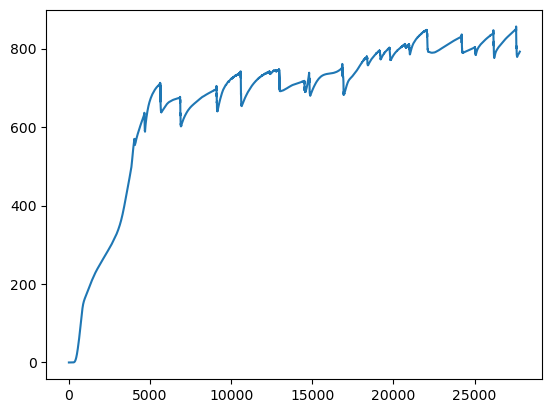

In [52]:
plt.plot(saved_kin)

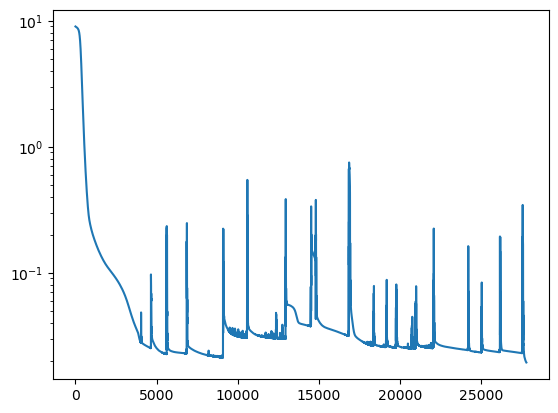

In [54]:
plt.plot(saved_loss)
plt.yscale('log')

In [13]:
np.min(saved_loss)

0.010278016

In [66]:
def forward_moving_average(arr, window_size):
    """
    Smooths a 1D NumPy array using a forward-looking moving average.
    
    Args:
        arr: Input 1D NumPy array
        window_size: Size of the forward-looking window
    
    Returns:
        Smoothed NumPy array of the same length
    """
    n = len(arr)
    smoothed = np.zeros(n)
    
    for i in range(n):
        # Take the mean of the current and future elements within the window
        end_idx = min(i + window_size, n)
        smoothed[i] = np.mean(arr[i:end_idx])
    
    return smoothed

# Example usage
arr = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
window_size = 1500
smoothed_arr = forward_moving_average(np.stack(saved_product1), window_size)
print(smoothed_arr)

[109.05754089 109.05418396 109.05052948 ...  -2.56078506  -2.54715276
  -2.52996135]


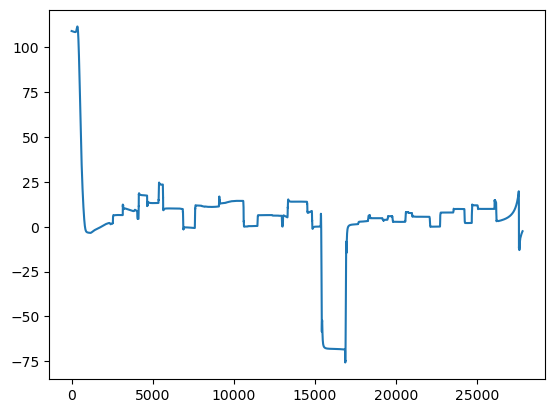

In [68]:
plt.plot(smoothed_arr)

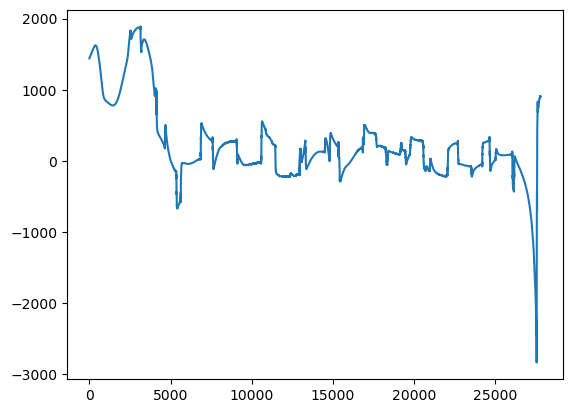

In [64]:
plt.plot(smoothed_arr)

In [28]:
saved_product1_00001=saved_product1
saved_product2_00001=saved_product2

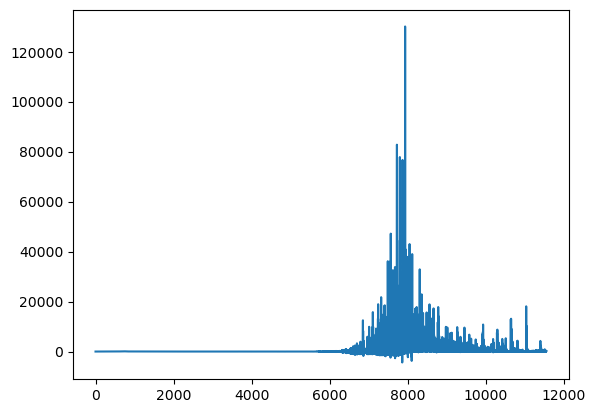

In [20]:
plt.plot(saved_product1)

In [ ]:
float32[16,4177]